In [1]:
import re
import io
import os
import sys
import csv
import glob
import gzip
import time
import json
import secrets
import pickle
import multiprocessing
import subprocess
import resource
import itertools
from itertools import combinations_with_replacement
import collections
import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import random
from collections import Counter
from collections import defaultdict
import copy
import pywfa
import pyranges as pr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    precision_score, recall_score, f1_score, accuracy_score
)
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

from scipy.stats import nbinom, norm, geom, beta, poisson
from scipy.special import logsumexp

sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

sys.path.append('/well/band/users/rbx225/GAMCC/scripts/lcSV/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/Low Coverage Data/gamcc/scripts/lcSV/')
from lcSV import *

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/
# %cd ../..

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

# Calling sex lcWGS

      sample    chrX    chrY sex
72   IDT0735  0.6028  0.4858   F
118  IDT0549  0.5612  0.4986   F
160  IDT0498  0.5774  0.4674   F


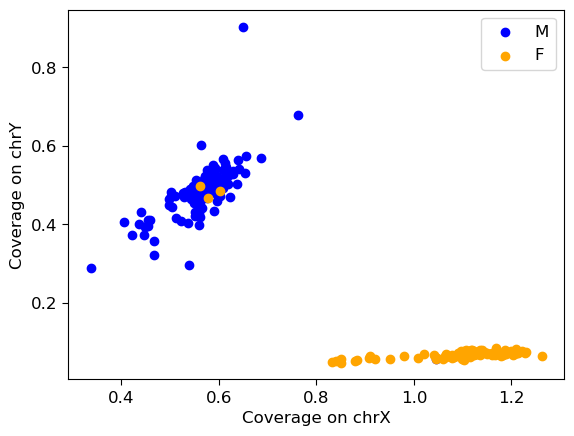

In [2]:
indir = 'results/coverage/sex/'
samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')

df_lst = []
for i in samples:
    df = pd.read_csv(f'{indir}{i}.sexchr.tsv', sep = '\t', header = None) 
    df.columns = ['sample', 'chrX', 'chrY']
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop = True)

metadata = pd.read_csv('data/metadata/sex.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

metadata = metadata[metadata['GMID'].isin(sl['Sample_Name'])]
sl = {k:v for k, v in zip(sl['Sample_Name'], sl['Seq_Name'])}
metadata['GMID'] = metadata['GMID'].apply(lambda x: sl[x])
metadata.columns = ['sample', 'sex']
df = pd.merge(df, metadata, on = 'sample')

labels = ['M', 'F']
colors = ['blue', 'orange']
for i, s in enumerate(labels):
    tmp = df[df['sex'] == s]
    if s == 'F':
        print(tmp[tmp['chrY'] > 0.2])
    plt.scatter(tmp['chrX'], tmp['chrY'], color = colors[i], label = s)
plt.xlabel('Coverage on chrX')
plt.ylabel('Coverage on chrY')
plt.legend()

# Coverage at specific regions

In [49]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

## GYP region

### DEL1

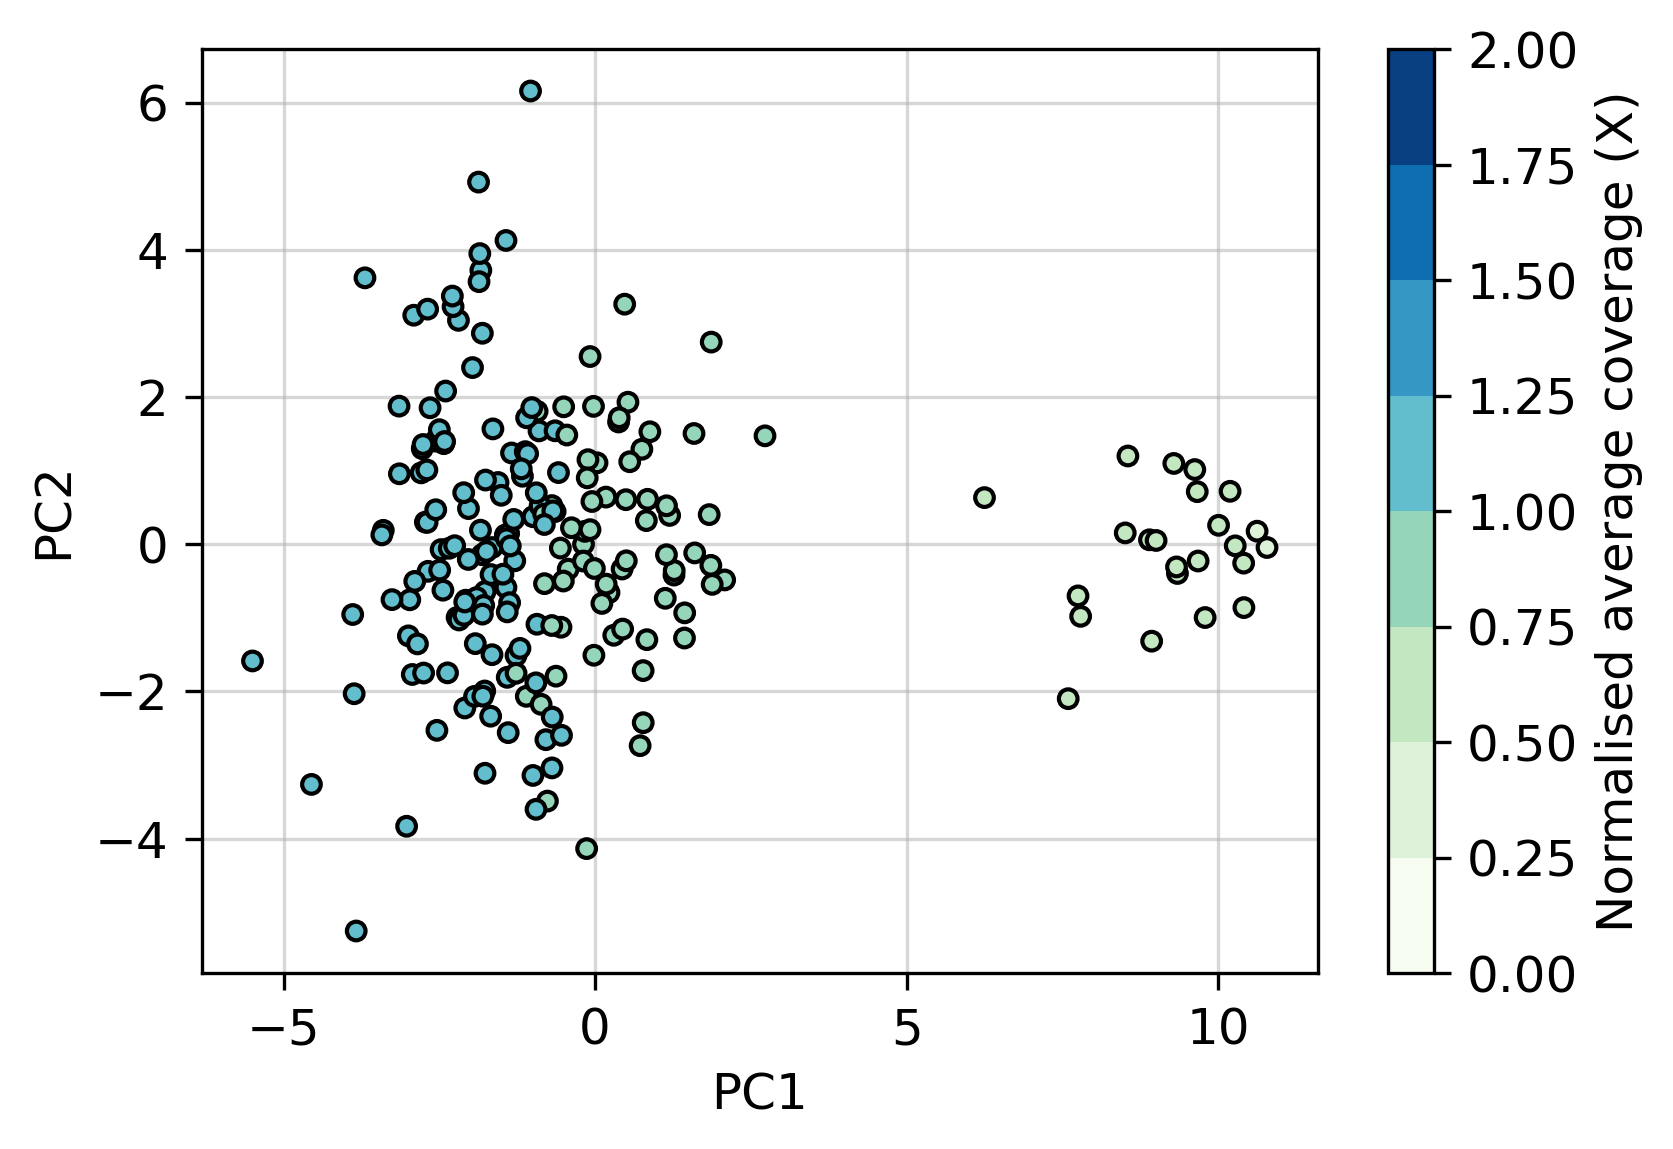

In [93]:
binsize = 1000
chromosome = 4
d1_start = 143910000
d1_end = 144030000
flank = d1_end - d1_start

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

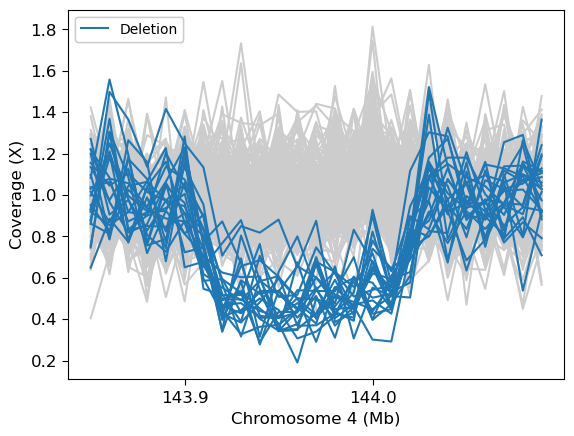

In [91]:
new_window = 10000
tick_step = 0.1
    
cov1 = deresolute_windows(cov, new_window, normalise = True)
del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)
    
ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

### DEL1 by Ethnicities

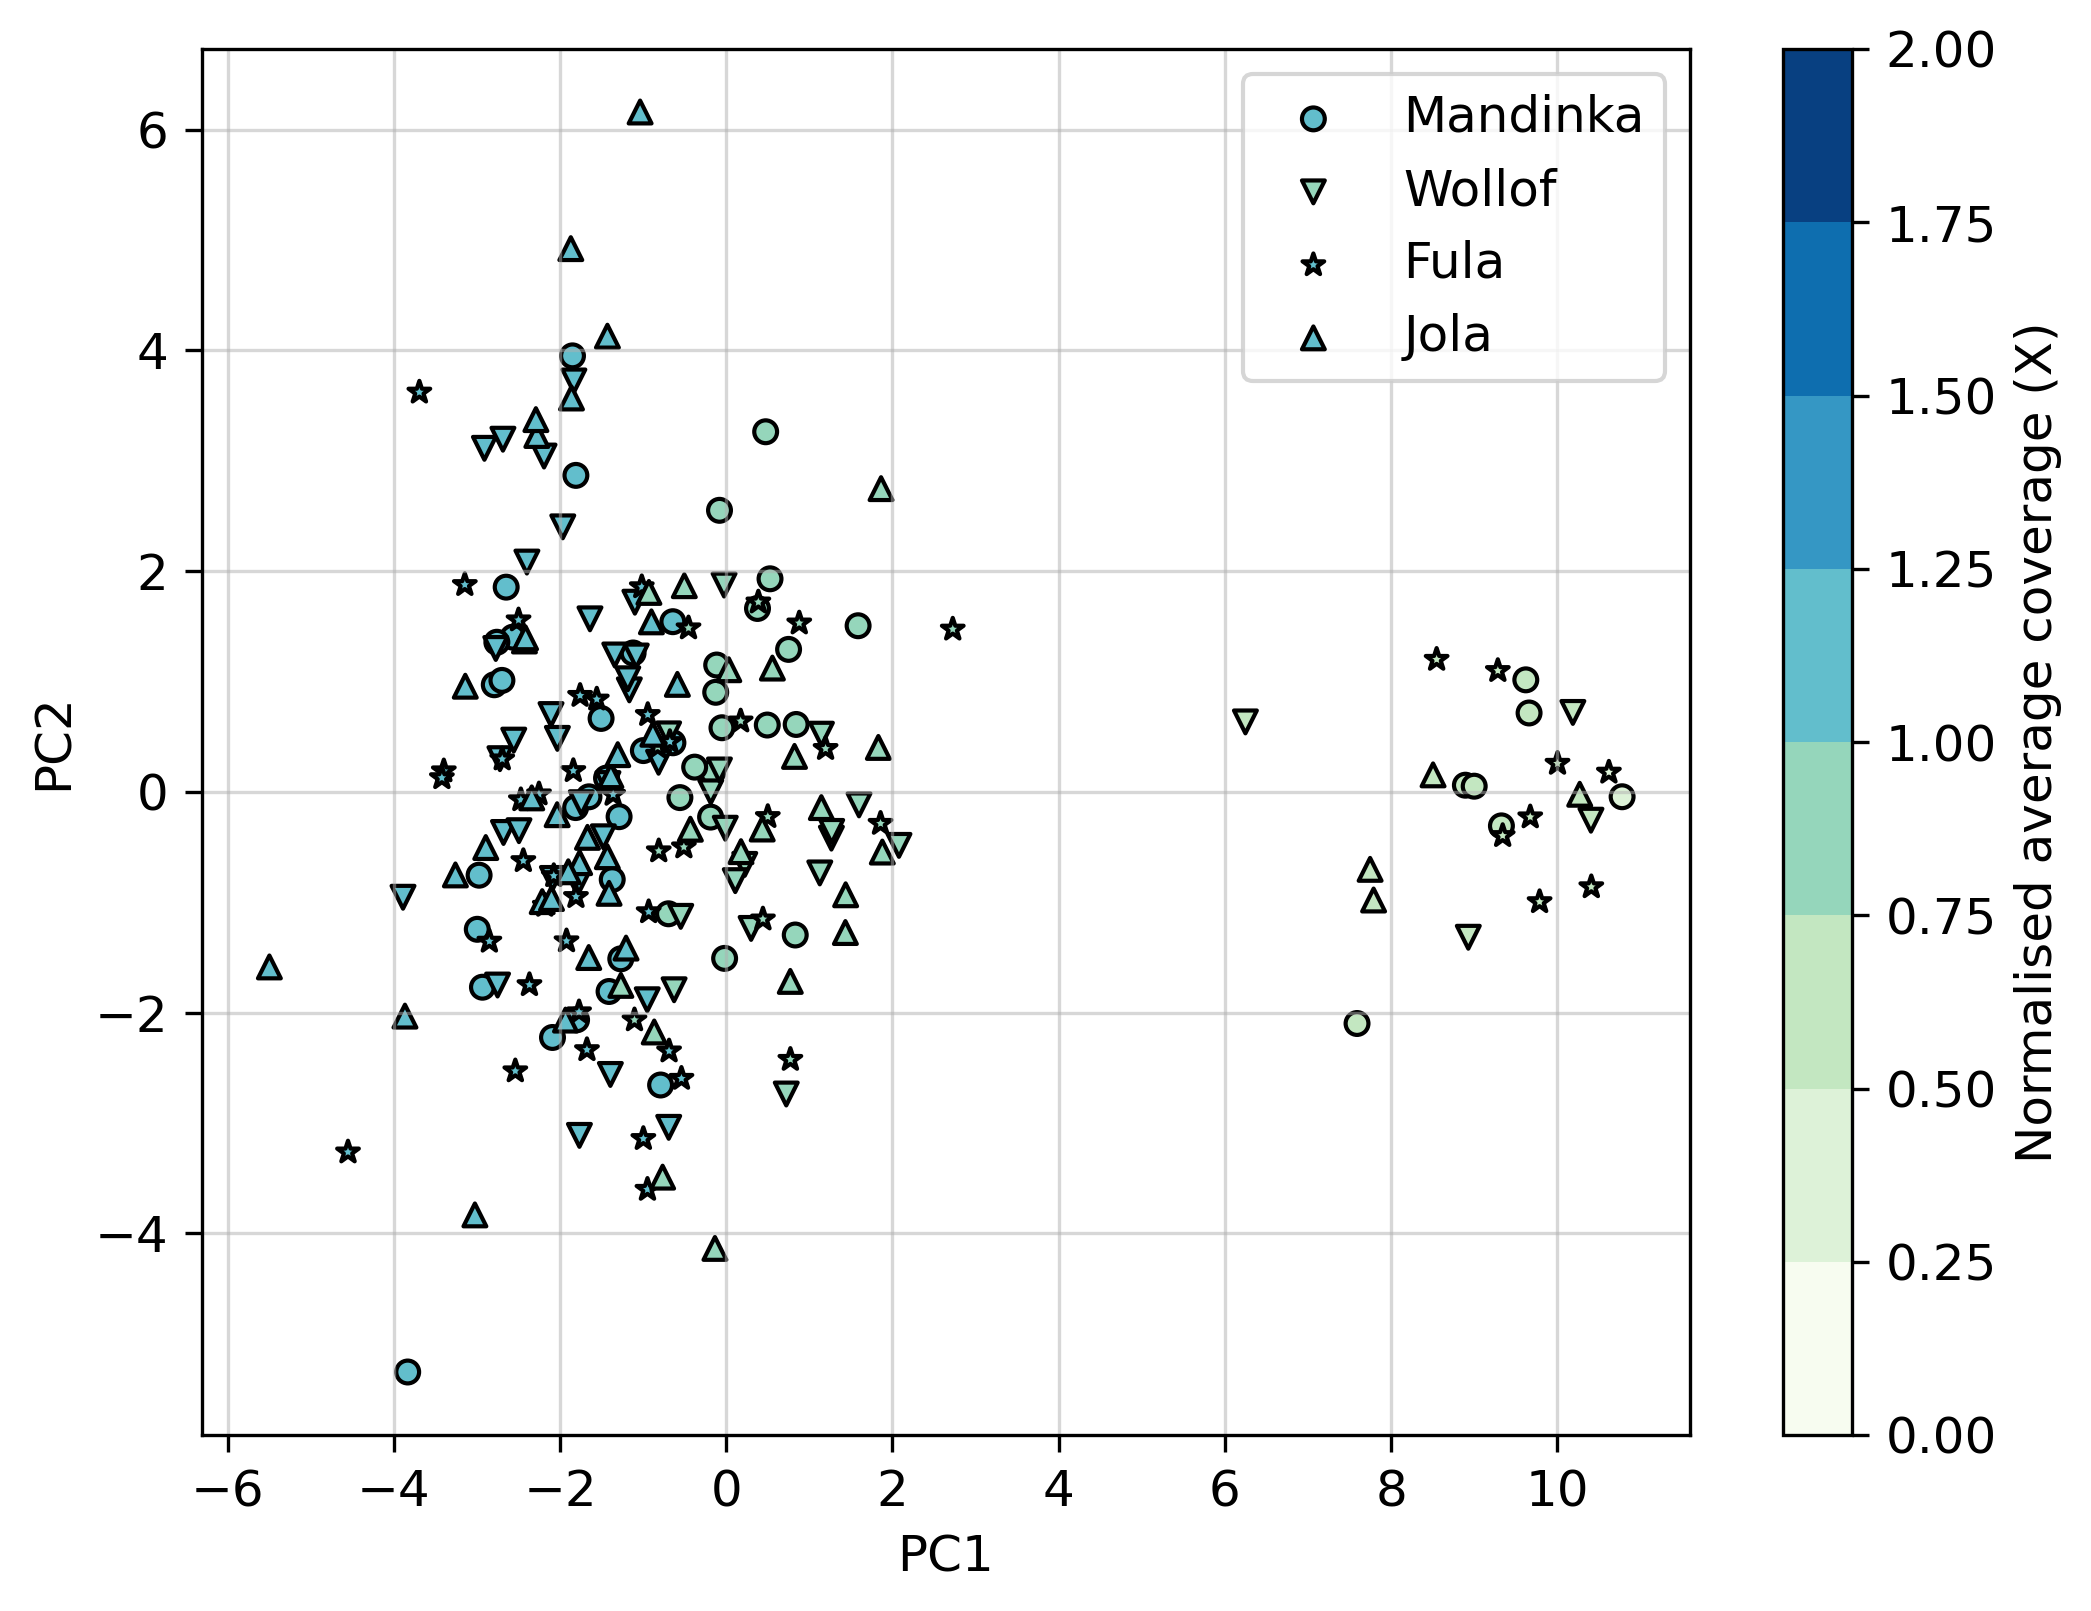

In [28]:
eth = pd.read_csv('data/metadata/ethnic_group.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

eth = eth[eth['Chip_Name'].isin(sl['Chip_Name'])]
sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Seq_Name'])}
eth['Chip_Name'] = eth['Chip_Name'].apply(lambda x: sl[x])
eth = eth.sort_values(by = 'Chip_Name').reset_index(drop = True)
ethnicities = eth['ethnic'].unique().tolist()

flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/(flank_cov.loc[s])

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(8, 6), dpi = 300)
for i, e in enumerate(ethnicities):
    tmp = pc_df[pc_df['ethnic'] == e]
    im = plt.scatter(tmp['PC1'], tmp['PC2'], c = tmp['cov'], marker = markers[i], 
                     cmap='GnBu', norm=norm, edgecolor='black', s = 30, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DEL2

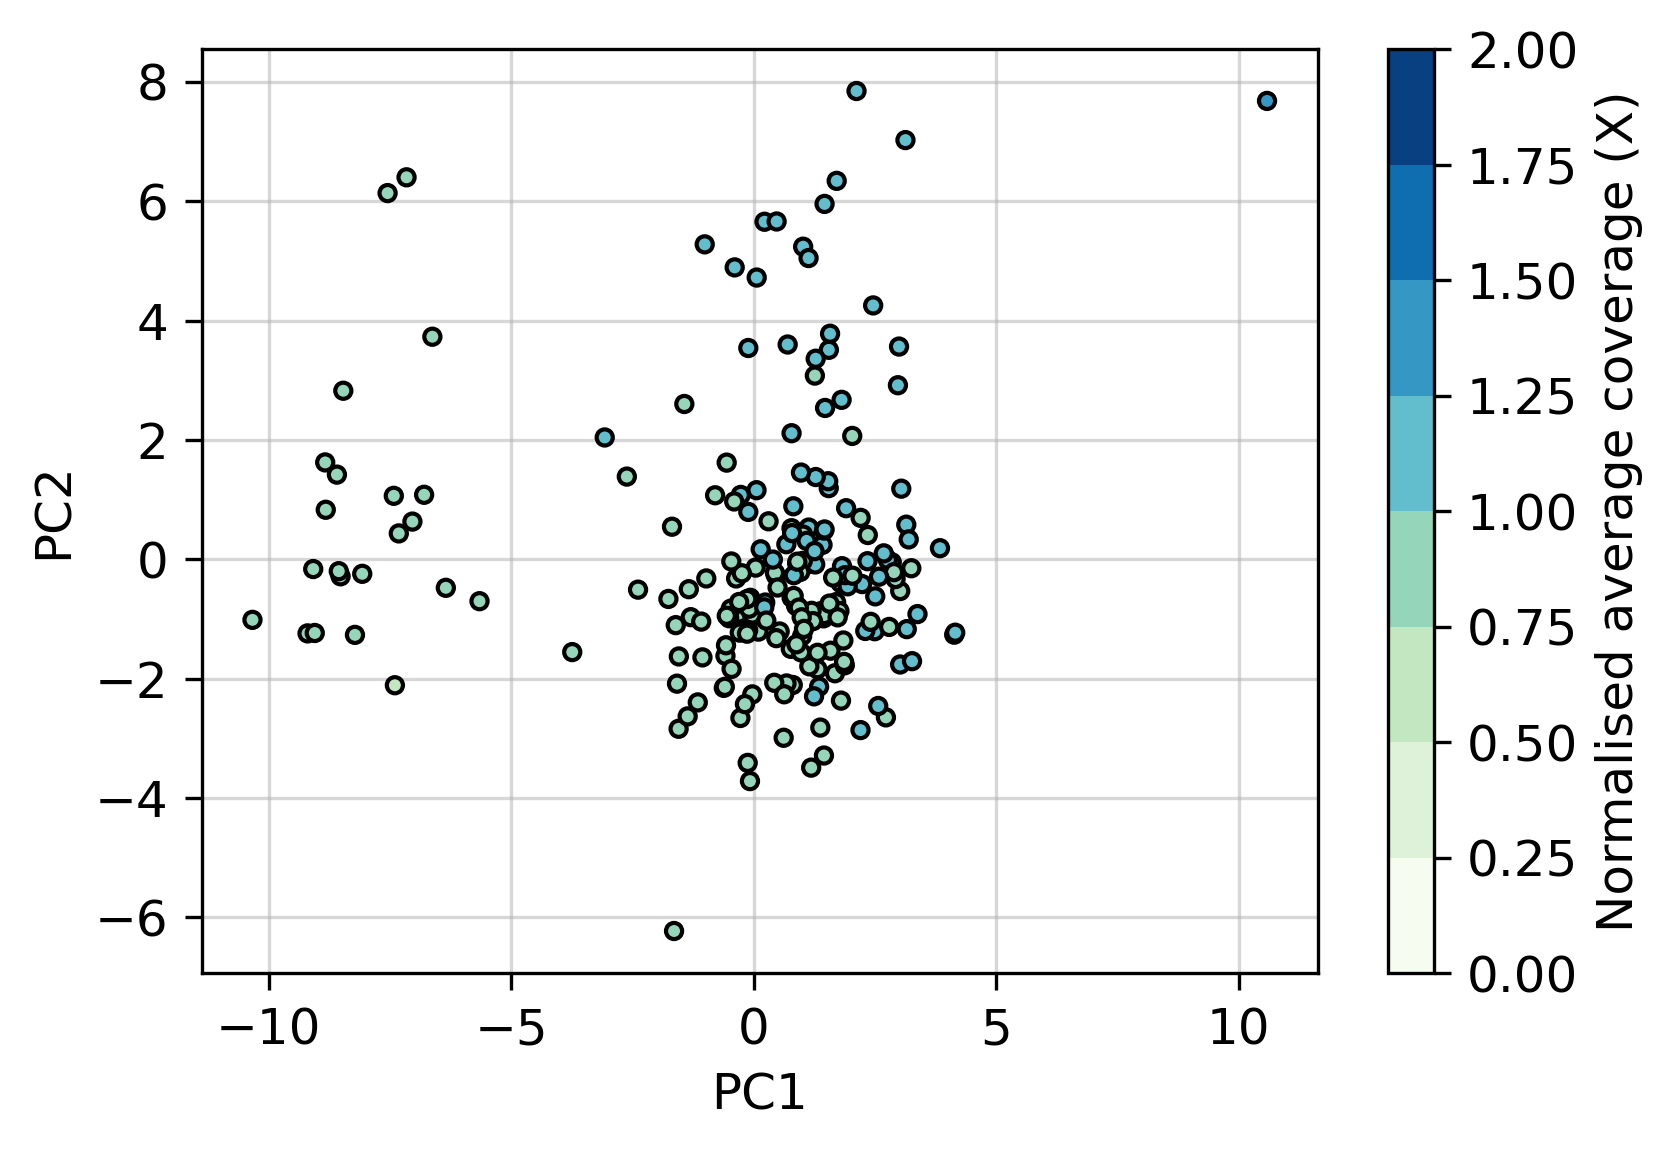

In [172]:
binsize = 1000
chromosome = 4
d1_start = 143780000
d1_end = 143780000 + 210000
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]


fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DUP1

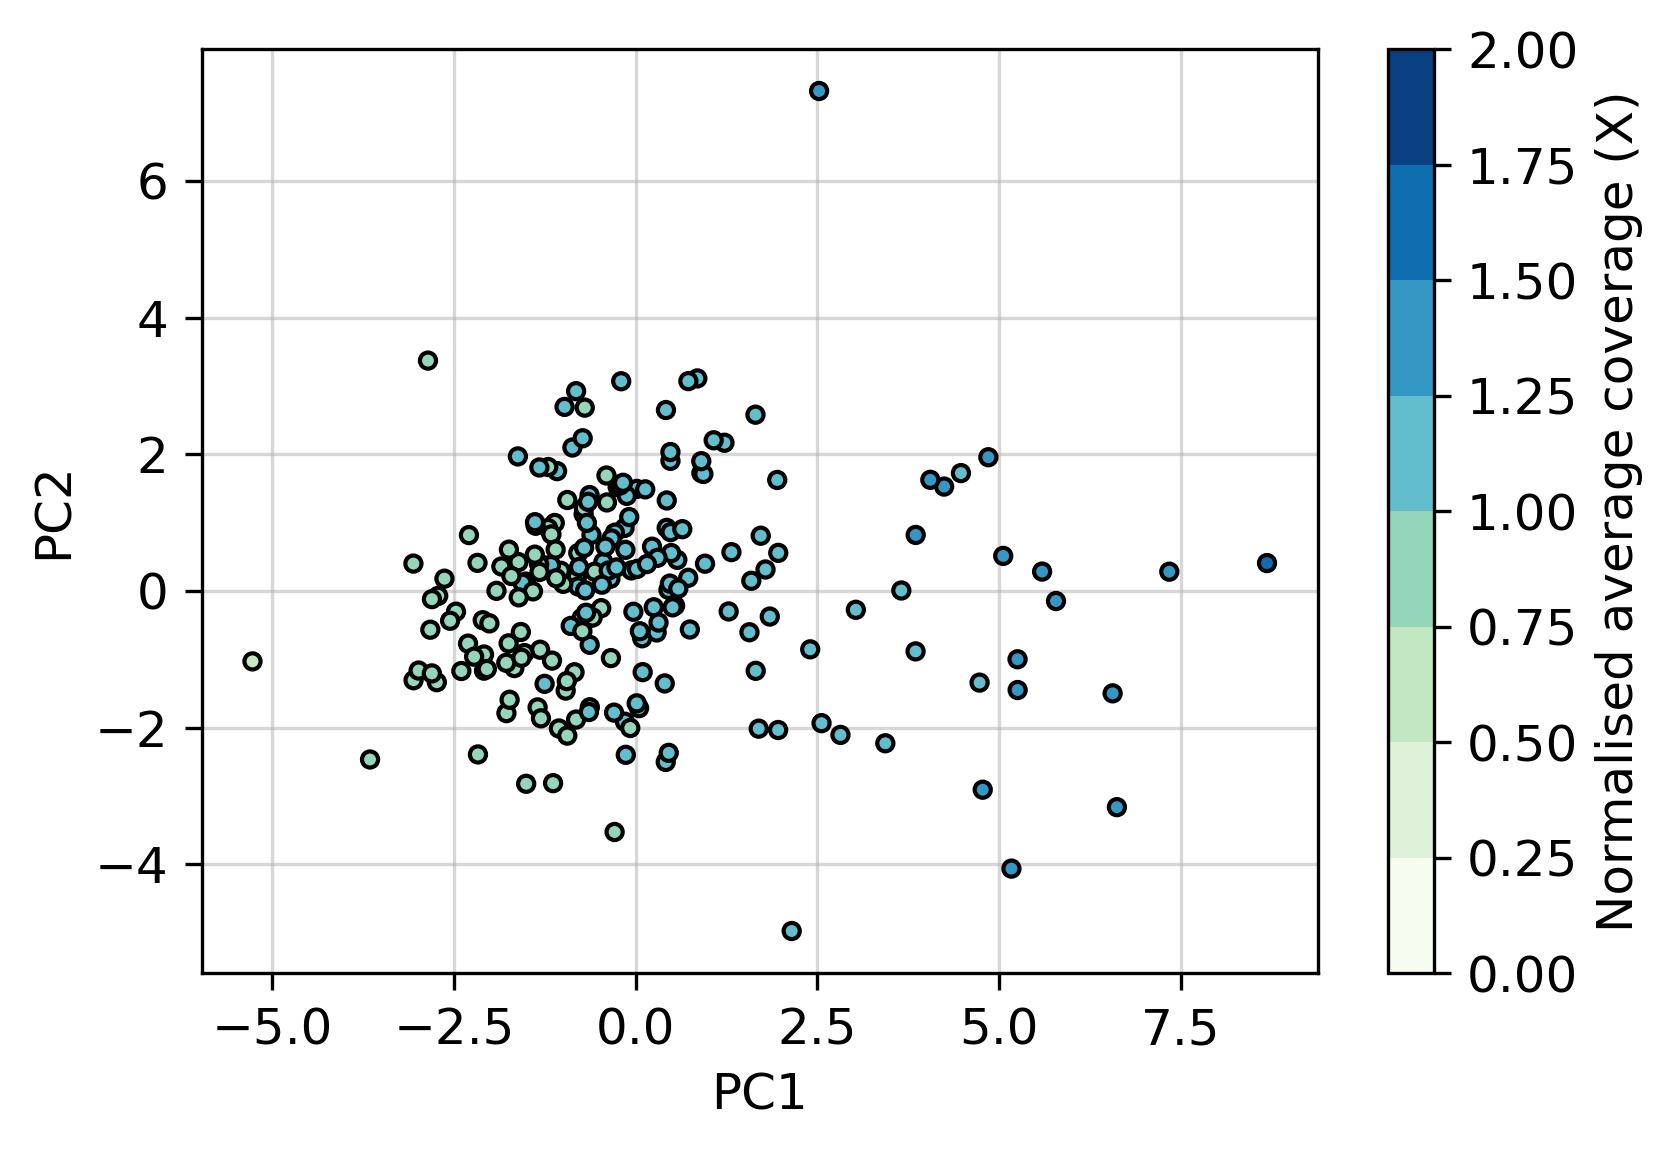

In [50]:
binsize = 1000
chromosome = 4
d1_start = 143790000
d1_end = 143850000
# d1_start = 143778847
# d1_end = 143878847
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]

fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

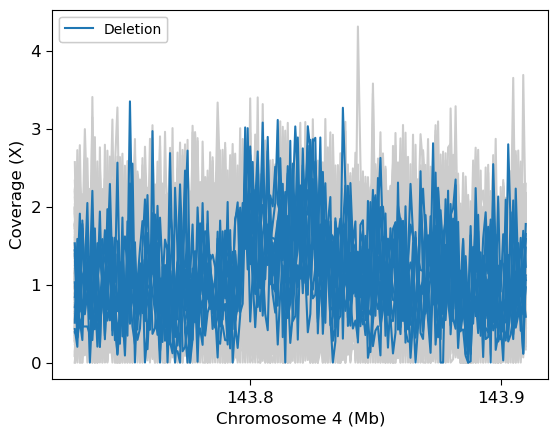

In [51]:
# new_window = 10000
# cov1 = deresolute_windows(cov, new_window, normalise = True)
cov1 = cov.copy()
tick_step = 0.1
e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)
del1_region = del1_region[(del1_region['position'] >= d1_start - flank) & (del1_region['position'] <= d1_end + flank)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

## HBA region

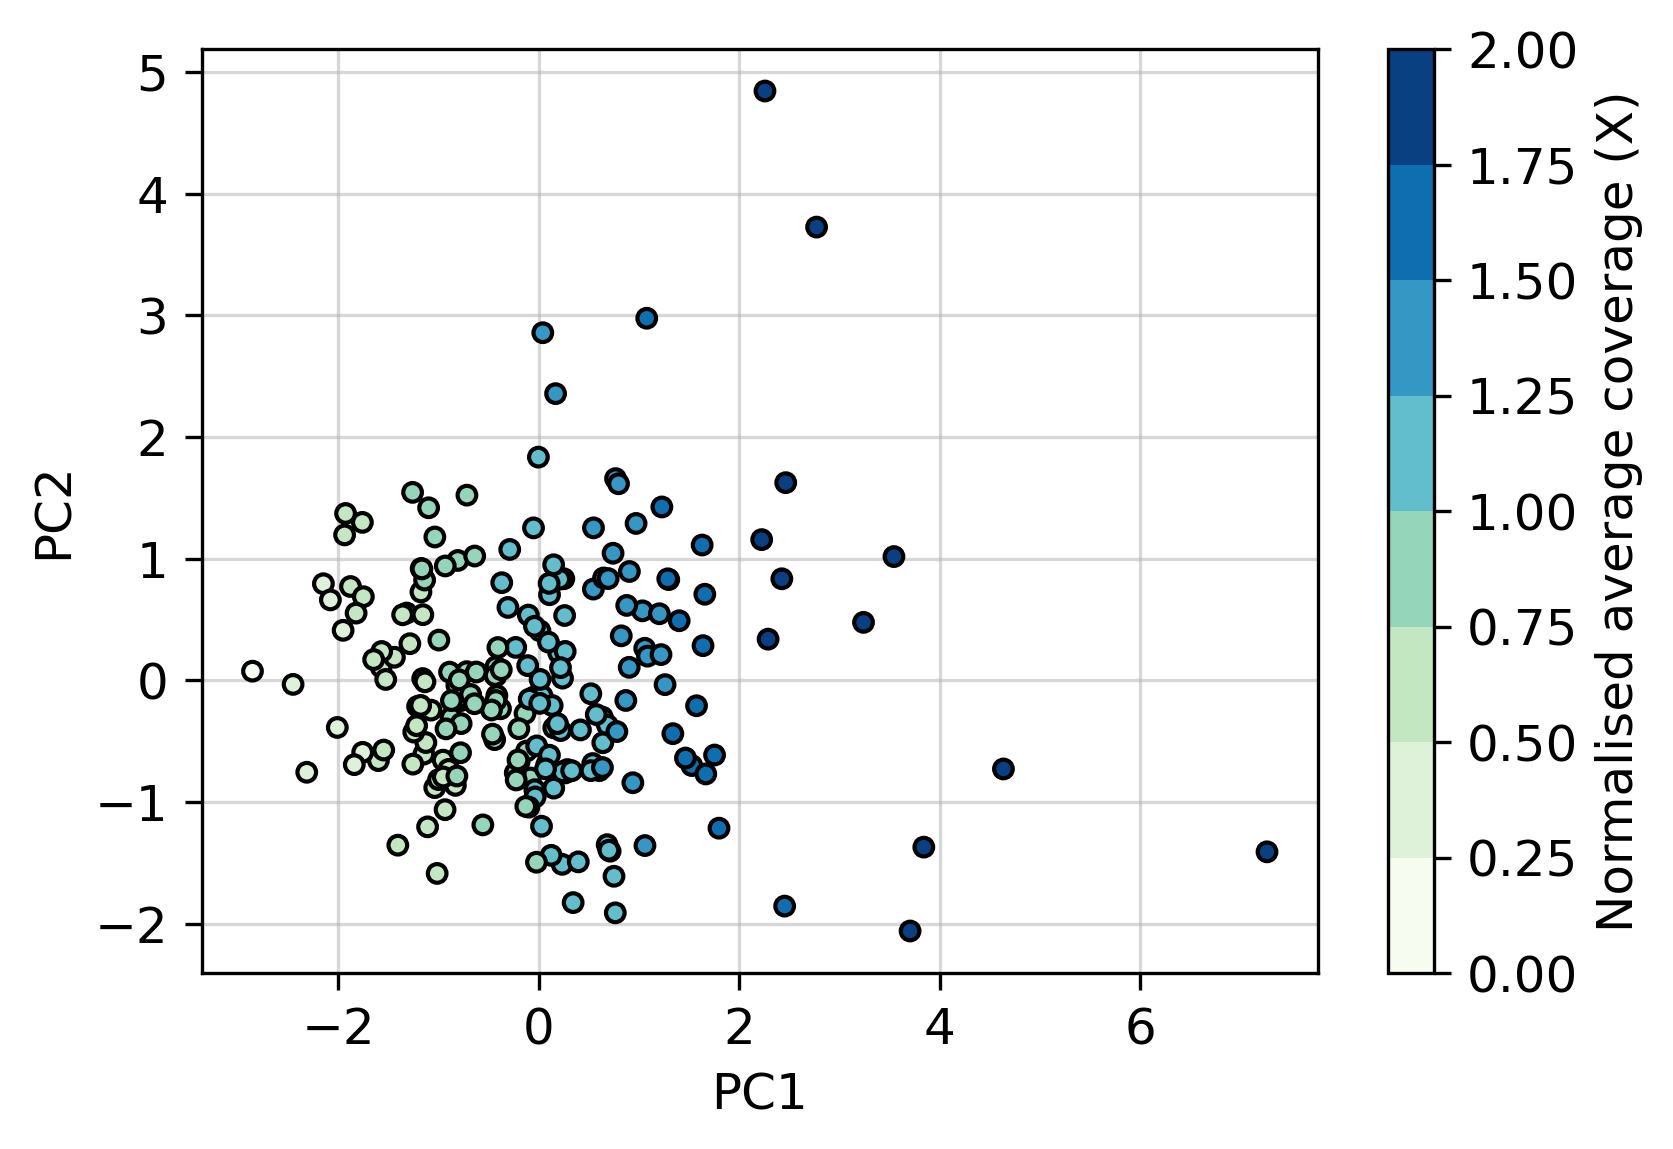

In [67]:
binsize = 300
chromosome = 16
d1_start = 173598
d1_end = 177378
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
# cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

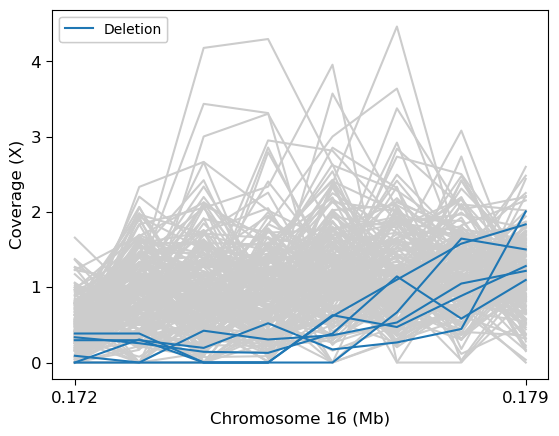

In [68]:
tick_step = 0.001
cutoff = -2

del1_region = cov1

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] >= cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] < cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

# ticks = get_ticks(del1_region, tick_step)
plt.xticks([del1_region.iloc[0,0], del1_region.iloc[-1,0]])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.ylabel('Coverage (X)')

# Nonahore

## Generate simulate data

In [20]:
N = 210
nb_var = 300
Ls = [6,12,18,24,30] # translate to 1k, 3k, 6.6k, 10k SVLEN
fs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

replicates = 100
ifiles = glob.glob('results/nonahore/simulate/plausibility/*/eval.pickle')

results_ary = []
for i, ifile in enumerate(ifiles):
    with open(ifile, 'rb') as of:
        data = pickle.load(of)

    results = pd.DataFrame(columns = ['len', 'maf', 'r2', 'info', 'maf_est.'])
    for k, v in data.items():
        results.loc[len(results)] = [float(h) for h in k.split('-')] + v
    results['len'] =  results['len'].apply(lambda x: Ls.index(x))
    results['rep'] = i
    results_ary.append(results)
    
df = pd.concat(results_ary).reset_index(drop = True)
avg = df.groupby(['len', 'maf']).mean().reset_index()

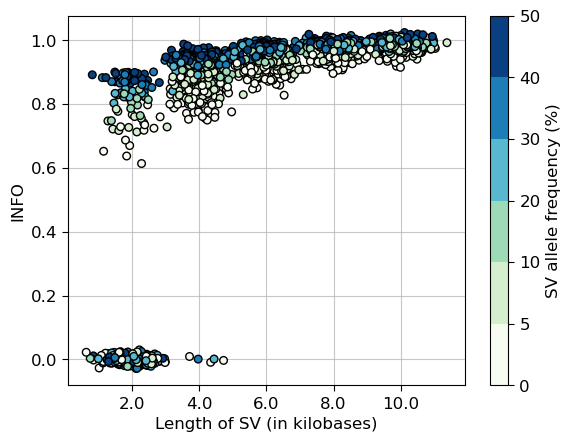

In [39]:
cmap = plt.get_cmap(COLORBAR_CMAP_STR)
magnitude = len(fs)

bounds = [0] + [f*100 for f in fs]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

metrics = 'info'
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(df))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(df))

im = plt.scatter(df['len'] + jitter_x, df[metrics] + jitter_y, c = (df['maf'] - 0.01)*100,
                    edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o', alpha = 1, zorder = 2)
    
plt.xticks(np.arange(len(Ls)), np.round(np.array(Ls)/3, 2))
plt.xlabel('Length of SV (in kbs)')
plt.ylabel('INFO')
plt.grid(alpha = 0.7, zorder = 1)
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='SV allele frequency (%)')

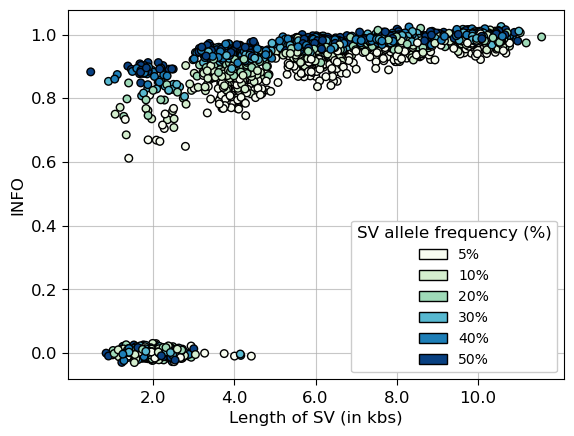

In [61]:
cmap = plt.get_cmap(COLORBAR_CMAP_STR)
bounds = [0] + [f*100 for f in fs]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

metrics = 'info'
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(df))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(df))

# scatter plot
im = plt.scatter(
    df['len'] + jitter_x, 
    df[metrics] + jitter_y, 
    c=(df['maf'] - 0.01)*100,
    edgecolor='black', cmap=cmap, norm=norm, 
    s=30, marker='o', alpha=1, zorder=2
)

plt.xticks(np.arange(len(Ls)), np.round(np.array(Ls)/3, 2))
plt.xlabel('Length of SV (in kbs)')
plt.ylabel('INFO')
plt.grid(alpha=0.7, zorder=1)


handles = []
for i in range(len(bounds) - 1):
    color = cmap(norm(bounds[i]))
    label = f"{int(bounds[i+1])}%"
    handles.append(mpatches.Patch(color=color, label=label, ec = 'black', alpha = 1))

plt.legend(handles=handles, title="SV allele frequency (%)", 
           frameon=True, loc='best', fontsize=10, framealpha = 1)
plt.show()

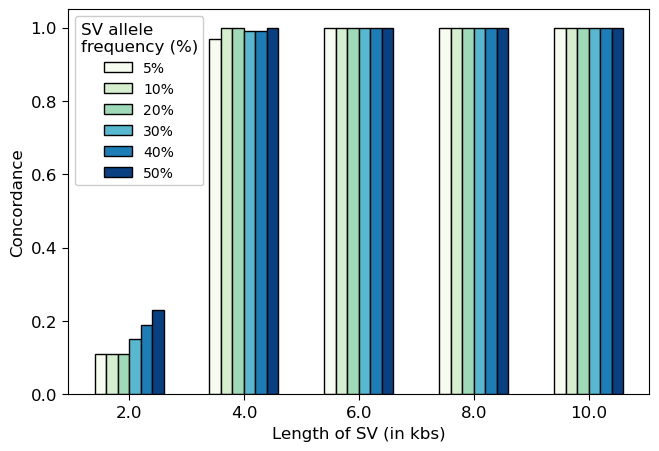

In [64]:
metrics = 'r2'

cmap = plt.get_cmap(COLORBAR_CMAP_STR)
magnitude = len(fs)

bounds = [0] + [f*100 for f in fs]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

jitter = [-0.25,-0.15,-0.05,0.05,0.15,0.25]
xaxis = []
xticks = []
bar_width = 0.1

plt.figure(figsize = (7.5,5))
for i, l in enumerate(Ls):
    tmp = avg[avg['len'] == i]
    plt.bar(tmp['len'] + np.array(jitter), tmp[metrics], width=bar_width, 
            color=cmap(norm(100*(tmp['maf'] - 0.01))), 
            edgecolor='black')

plt.xticks(np.arange(len(Ls)), np.round(np.array(Ls)/3, 2))
plt.xlabel('Length of SV (in kbs)')
plt.ylabel('Concordance')
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# plt.colorbar(sm, boundaries=bounds, ticks=bounds, label='SV allele frequency (%)')

handles = []
for i in range(len(bounds) - 1):
    color = cmap(norm(bounds[i]))
    label = f"{int(bounds[i+1])}%"
    handles.append(mpatches.Patch(color=color, label=label, ec = 'black', alpha = 1))

plt.legend(handles=handles, title="SV allele\nfrequency (%)", 
           frameon=True, loc='best', fontsize=10, framealpha = 1)
plt.show()

Text(0, 0.5, 'Concordance')

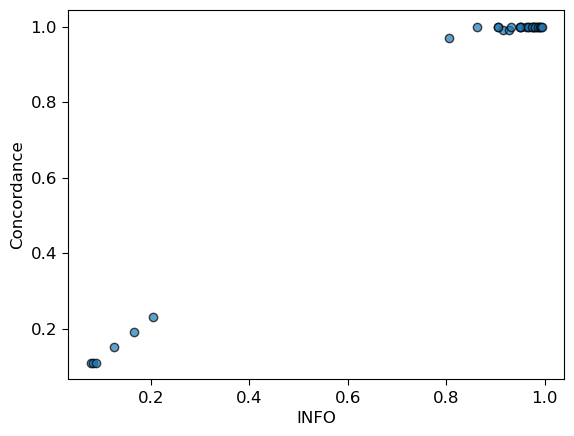

In [50]:
plt.scatter(avg['info'], avg['r2'], ec = 'black', alpha = 0.7)
plt.xlabel('INFO')
plt.ylabel('Concordance')

### Testing a single case

In [67]:
N = 210
nb_vars = 100
Ls = 10
fs = 0.05
replicates = 1
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

n_recomb = 200
n_iter = 500
verbose = False

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0
model = SVModel([h1,h2], [1-f1,f1])
training, coverage, true_gt = simulate_coverotron(model, N, l, mean_coverage, sd_coverage, v)

eval_dict = {}
means = np.mean(training, axis = 0)
variances = np.var(training, axis = 0, ddof = 1)
result_dict = nonahore(means, variances, coverage, n_recomb = n_recomb, n_iter = n_iter, verbose = verbose)
                
concordance, info, freq = evaluate_sim_model(result_dict, h2, true_gt)
concordance, info, freq

(1.0, 1.0, 0.14522695332433527)

## Simulation

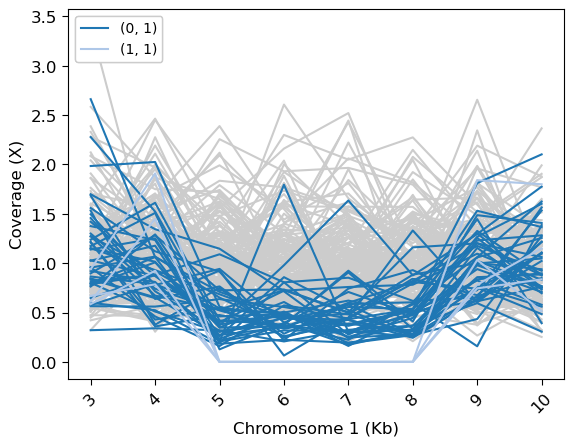

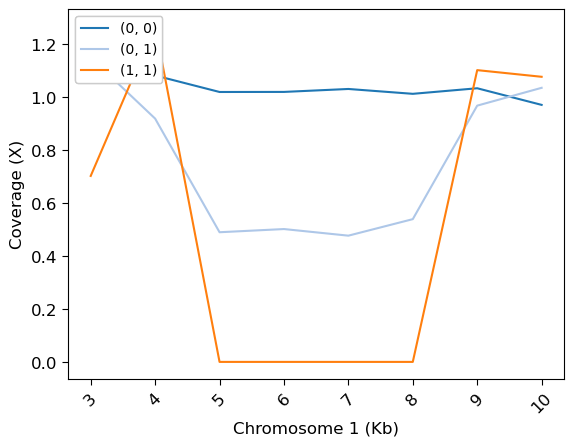

In [195]:
# ploidy = 2
# geom_penalty = 0.9
# max_cnv = 10
# n_iter = 10
# n_sample_freq = 200
# n_recomb = 1000

# indir = "results/nonahore/simulate/plausibility/rep12/"
# cov_file = f"{indir}12-0.1-training.txt"
# covs = pd.read_csv(cov_file, header = None, sep = '\t').to_numpy()
# means = np.mean(covs, axis = 0)
# variances = np.var(covs, axis = 0, ddof = 1)
# # Instead of loading from a file we can also input the matrix

# cov_file = f"{indir}12-0.1-coverage.txt"
# covs = pd.read_csv(cov_file, header = None, sep = '\t').to_numpy()

# results = nonahore(means, variances, covs, n_iter = 50)

# plot_training(results)
# plt.show()

best_model = results['model_ary'][-1]
samples = [f'samples_{i}' for i in range(1,211)]
calling_dict = dict(sorted(call_sv_samples(samples, results['genotypes']).items()))

cov_df = pd.DataFrame(covs, columns = [f'samples_{i}:coverage' for i in range(1,211)])
cov_df['position'] = np.arange(len(cov_df))*1000 + 1000
cov_df = cov_df[['position'] + [f'samples_{i}:coverage' for i in range(1,211)]]
cov_df['total:coverage'] = 0

plot_sv_coverage(cov_df, 1, 3000, 10000, 3000, calling_dict, tick_step = 0.001)
plt.show()
plot_sv_coverage_by_gt(cov_df, 1, 3000, 10000, 3000, calling_dict, tick_step = 0.001)
plt.show()

## GYP: DEL1 and DEL2

------ Iteration 5 ------
Best loglikelihood: 49376.279197942524
------ Iteration 10 ------
Best loglikelihood: 49376.267051133895
------ Iteration 15 ------
Best loglikelihood: 49376.2617647217
------ Iteration 20 ------
Best loglikelihood: 49376.261731169245
------ Iteration 25 ------
Best loglikelihood: 49376.261731169245
------ Iteration 30 ------
Best loglikelihood: 49376.26170506141
------ Iteration 35 ------
Best loglikelihood: 49376.26170506141
------ Iteration 40 ------
Best loglikelihood: 49376.26170506141
------ Iteration 45 ------
Best loglikelihood: 49376.26170506141
------ Iteration 50 ------
Best loglikelihood: 49376.26170506141
------ Iteration 55 ------
Best loglikelihood: 49376.26170506141
------ Iteration 60 ------
Best loglikelihood: 49376.26170506141
------ Iteration 65 ------
Best loglikelihood: 49376.26170506141
------ Iteration 70 ------
Best loglikelihood: 49376.26170506141
------ Iteration 75 ------
Best loglikelihood: 49376.26170506141
------ Iteration 80 ---

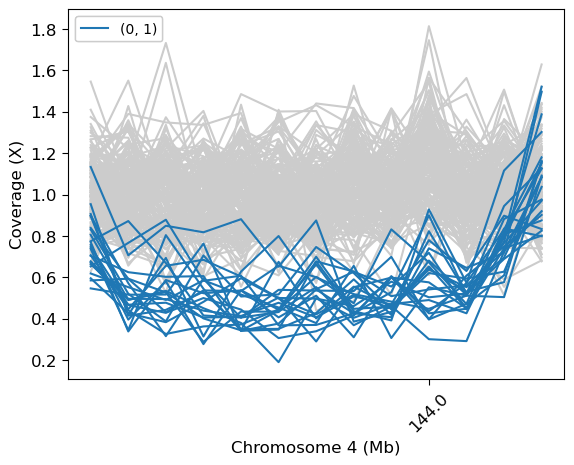

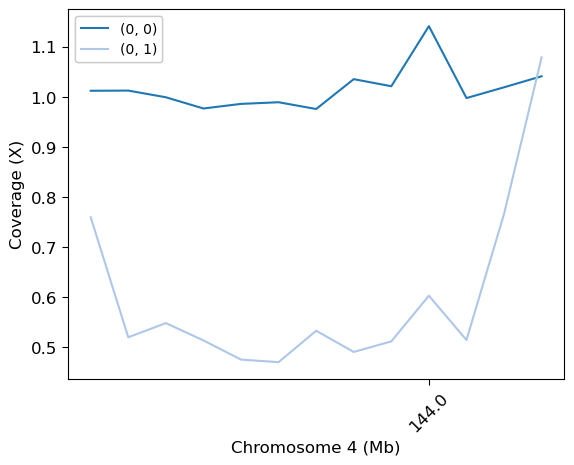

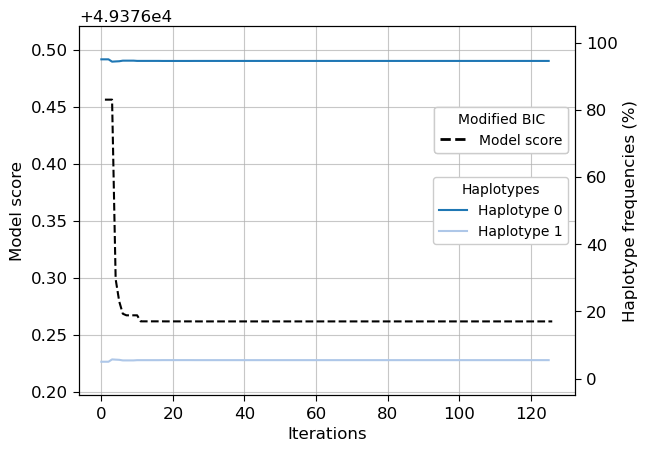

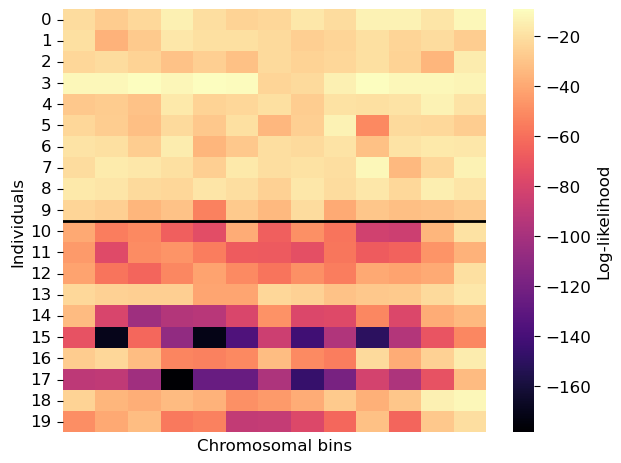

In [18]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 10000
chromosome = 4
start = 143910000
end = 144030000
flank = end - start
svtype = 'DEL'
plausible_boundaries = start, end

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov1 = deresolute_windows(cov, bin_size, normalise = False)
cov = cov1.copy()

means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance, true_hap_idx = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
plot_sv_heatmap(means, variances, coverage, samples, results)
plt.show()

## DUP1

------ Iteration 5 ------
Best loglikelihood: 30591.673671724904
------ Iteration 10 ------
Best loglikelihood: 30591.65095011001
------ Iteration 15 ------
Best loglikelihood: 30591.64931381658
------ Iteration 20 ------
Best loglikelihood: 30591.64931381658
------ Iteration 25 ------
Best loglikelihood: 30591.649232346048
------ Iteration 30 ------
Best loglikelihood: 30591.649232308217
------ Iteration 35 ------
Best loglikelihood: 30591.649232308217
------ Iteration 40 ------
Best loglikelihood: 30591.649232167754
------ Iteration 45 ------
Best loglikelihood: 30591.649232167754
------ Iteration 50 ------
Best loglikelihood: 30591.649232167754
------ Iteration 55 ------
Best loglikelihood: 30591.649232167754
------ Iteration 60 ------
Best loglikelihood: 30591.649232167754
------ Iteration 65 ------
Best loglikelihood: 30591.649232167754
------ Iteration 70 ------
Best loglikelihood: 30591.649232167754
------ Iteration 75 ------
Best loglikelihood: 30591.649232167754
------ Iterati

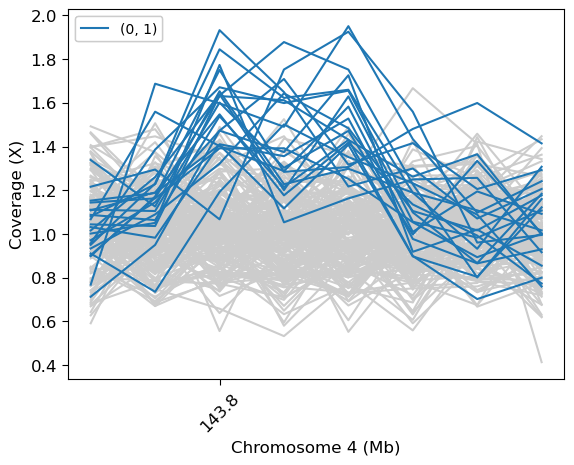

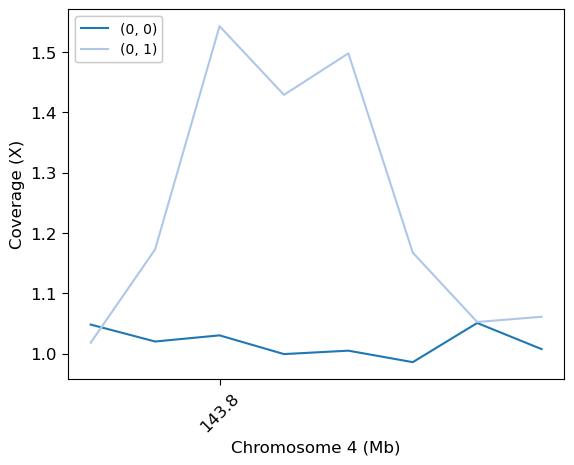

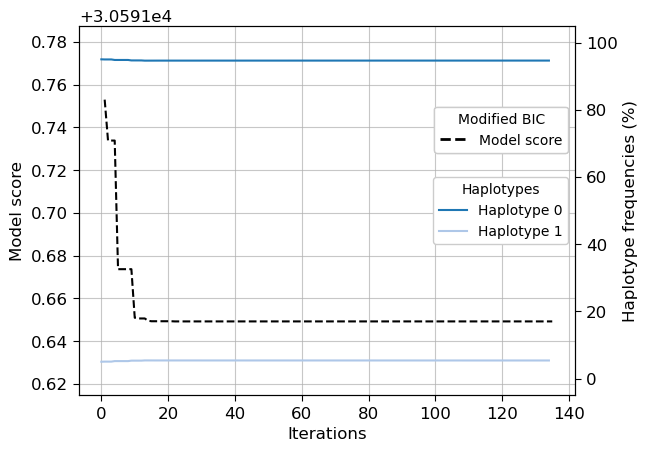

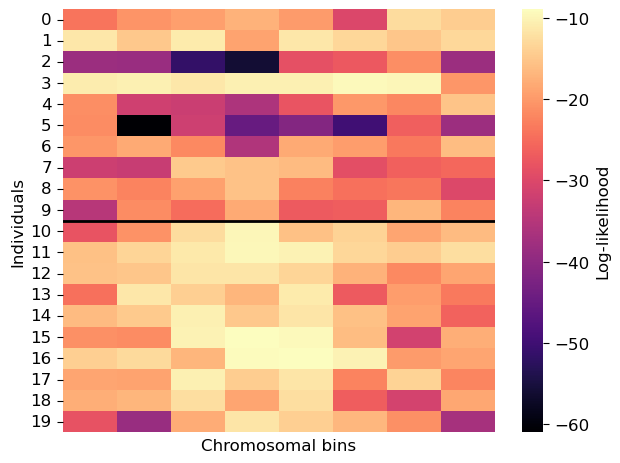

In [19]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 10000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start
svtype = 'INS'
plausible_boundaries = start, end

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov1 = deresolute_windows(cov, bin_size, normalise = False)
cov = cov1.copy()

means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance, true_hap_idx = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
plot_sv_heatmap(means, variances, coverage, samples, results)
plt.show()

## HBA

In [15]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 16
start = 160000
end = 190000
flank = end-start
# flank = 1e5

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank, side = 'right')
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

------ Iteration 5 ------
Best loglikelihood: 104041.73629631563
------ Iteration 45 ------
Best loglikelihood: 103665.06128701578
------ Iteration 50 ------
Best loglikelihood: 103665.06128701578
------ Iteration 55 ------
Best loglikelihood: 103665.06128701578
------ Iteration 60 ------
Best loglikelihood: 103665.06128701578
------ Iteration 65 ------
Best loglikelihood: 103665.06128701578
------ Iteration 70 ------
Best loglikelihood: 103665.06128701578
------ Iteration 75 ------
Best loglikelihood: 103665.06128701578
------ Iteration 80 ------
Best loglikelihood: 103665.06128701578
------ Iteration 85 ------
Best loglikelihood: 103665.06128701578
------ Iteration 90 ------
Best loglikelihood: 103665.06128701578
------ Iteration 95 ------
Best loglikelihood: 103665.06128701578
------ Iteration 100 ------
Best loglikelihood: 103665.06128701578
------ Iteration 105 ------
Best loglikelihood: 103665.06128701578
------ Iteration 110 ------
Best loglikelihood: 103665.06128701578
------ I

In [16]:
best_model.haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.]),
 array([1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.])]

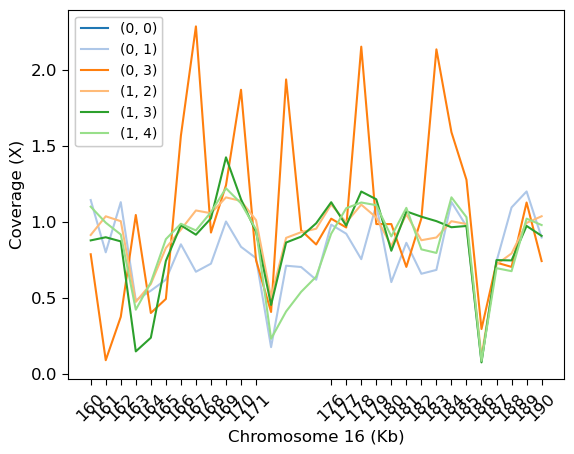

In [199]:
# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict, tick_step = 0.001)
# plt.show()
# plot_training(results, show_legends = True)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)
# plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict, tick_step = 0.001)
plt.show()

------ Iteration 5 ------
Best loglikelihood: 72000.46881464103
------ Iteration 10 ------
Best loglikelihood: 71997.95910983323
------ Iteration 15 ------
Best loglikelihood: 71997.95910983323
------ Iteration 20 ------
Best loglikelihood: 71997.95910983323
------ Iteration 25 ------
Best loglikelihood: 71997.95910983323
------ Iteration 30 ------
Best loglikelihood: 71997.39152833034
------ Iteration 35 ------
Best loglikelihood: 71997.34825042705
------ Iteration 40 ------
Best loglikelihood: 71997.34825042705
------ Iteration 45 ------
Best loglikelihood: 71997.34825042705
------ Iteration 50 ------
Best loglikelihood: 71997.34825042705
------ Iteration 55 ------
Best loglikelihood: 71997.32907647727
------ Iteration 60 ------
Best loglikelihood: 71997.07849313229
------ Iteration 65 ------
Best loglikelihood: 71997.07849313229
------ Iteration 70 ------
Best loglikelihood: 71997.07849313229
------ Iteration 75 ------
Best loglikelihood: 71997.07849313229
------ Iteration 80 ------

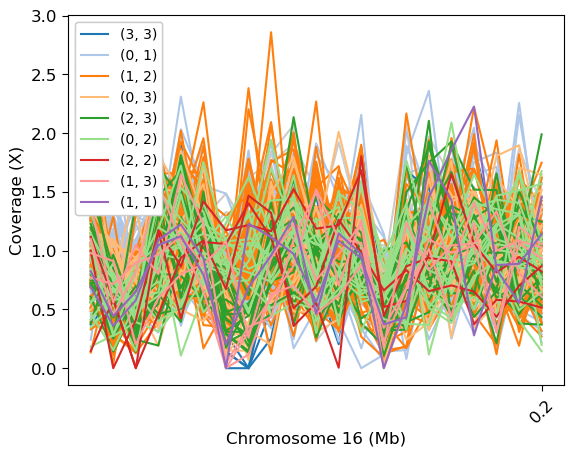

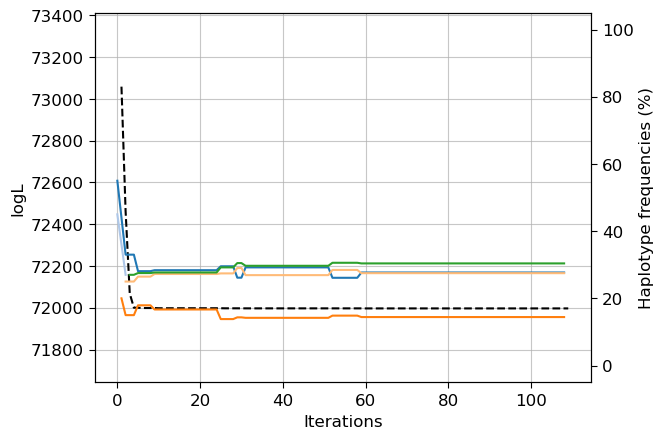

In [7]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 2000
chromosome = 16
start = 160000
end = 200000
flank = end - start

cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, 
                   n_recomb = 2000, n_iter = 500, bin_size = bin_size, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = False)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

In [8]:
best_model.haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.])]

## Eichler

### Eichler generate manifest

In [70]:
# df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
# main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
# df = df[df['#CHROM'].isin(main_chrs)]
# df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
# df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
# df = df[(df['SVLEN'] > 5000) & ((df['POP_AFR_AF'] >= 0.05) | (df['PG_AFR_AF'] >= 0.05))]
# df = df[['#CHROM', 'POS', 'END', 'SVTYPE', 'SVLEN','PG_AFR_AF', 'POP_AFR_AF']].reset_index(drop = True)
# df.to_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t', index = False)

df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

#CHROM        POS        END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
0      chr8  125582877  125588890    DEL   6013       0.98         1.0
1      chr5   58384165   58390274    DEL   6109       1.00         1.0
2     chr17   72880950   72880951    INS   8066       0.40         1.0
3     chr17   72859877   72859878    INS   6353       1.00         1.0
4      chr3   47784344   47784345    INS   8154       0.87         1.0
...     ...        ...        ...    ...    ...        ...         ...
1174   chr2  143253209  143253210    INS   6066       0.08         0.0
1175   chr2  146105051  146119294    DEL  14243       0.10         0.0
1176   chr2  195227939  195227940    INS   5659       0.06         0.0
1177   chr2  226090355  226097389    DEL   7034       0.06         0.0
1178   chr2  229476839  229476840    INS   6030       0.06         0.0

[1179 rows x 7 columns]

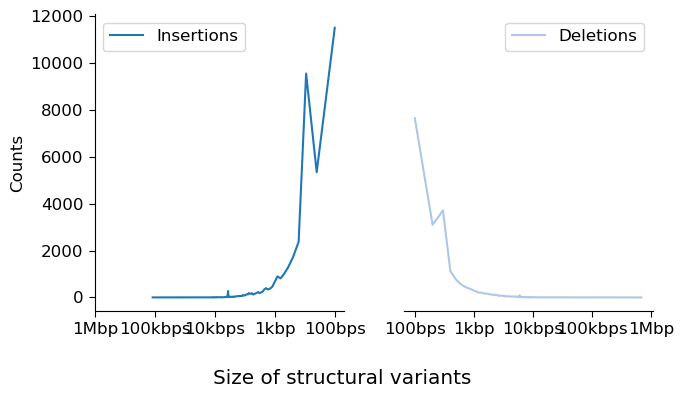

In [59]:
df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
df = df[df['#CHROM'].isin(main_chrs)]
df = df[df['SVLEN'] > 100]
df = df[['SVLEN', 'SVTYPE']]

bin_size = 100
df['bin'] = (df['SVLEN'] // bin_size) * bin_size

insertion = df[df['SVTYPE'] == 'INS']
ins_counts = insertion['bin'].value_counts().sort_index()

deletion = df[df['SVTYPE'] == 'DEL']
del_counts = deletion['bin'].value_counts().sort_index()

xticks = np.logspace(2,6,5)
xlabels = ['100bps', '1kbp', '10kbps', '100kbps', '1Mbp']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
colors = [mcolors.to_hex(color) for color in colors]

ax1.plot(ins_counts.index, ins_counts.values, color=colors[0], label = 'Insertions')
ax2.plot(del_counts.index, del_counts.values, color=colors[1], label = 'Deletions')

ax1.legend()
ax2.legend()
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_ylabel('Counts')
ax1.set_xticks(xticks, xlabels)
# ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xticks(xticks, xlabels)
# ax2.set_yscale('log')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False if ax is ax2 else True)  # keep y-axis on leftmost
    ax.spines['bottom'].set_visible(True)

ax2.tick_params(labelleft=False)
ax2.tick_params(axis='y', which='both', length=0)

ax1.tick_params(axis='x', which='minor', length=0)
ax2.tick_params(axis='x', which='minor', length=0)

fig.supxlabel('Size of structural variants')
plt.tight_layout()
plt.show()

In [101]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

ix = 932
chrom, start, L, svtype = df.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region(start, L)
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

# probs, genotypes = results['probs'], results['genotypes']
# info, freq = evaluate_real_model(results)
# haps = results['model_ary'][-1].haps

# outputs = {}
# outputs['chromosome'] = chrom
# outputs['start'] = start
# outputs['end'] = end
# outputs['length'] = L
# outputs['svtype'] = svtype
# outputs['means'] = means
# outputs['variances'] = variances
# outputs['coverage'] = coverage
# outputs['info'] = info
# outputs['freq'] = freq
# outputs['haps'] = haps
# outputs['probs'] = np.round(probs, 4)
# outputs['genotypes'] = genotypes

# best_model = results['model_ary'][-1]
# calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# # plot_sv_heatmap(means, variances, coverage, samples, results)

------ Iteration 5 ------
Best loglikelihood: 2147679.032761865
------ Iteration 10 ------
Best loglikelihood: 2001036.6233875803


Process ForkPoolWorker-5899:
Process ForkPoolWorker-5898:
Process ForkPoolWorker-5910:
Process ForkPoolWorker-5905:
Process ForkPoolWorker-5897:
Process ForkPoolWorker-5908:
Process ForkPoolWorker-5901:
Process ForkPoolWorker-5896:
Process ForkPoolWorker-5900:
Process ForkPoolWorker-5909:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-5904:
Process ForkPoolWorker-5907:
Process ForkPoolWorker-5903:
Process ForkPoolWorker-5906:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multip

  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 311, in evaluate_per_hap
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 283, in multi_evaluate_model
    final_lls = np.zeros((N, n_diploid))
Traceback (most recent call last):
KeyboardInterrupt
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 278, in multi_evaluate_model
    if L is None:
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 278, in multi_evaluate_model
    if L is None:
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starm

KeyboardInterrupt: 

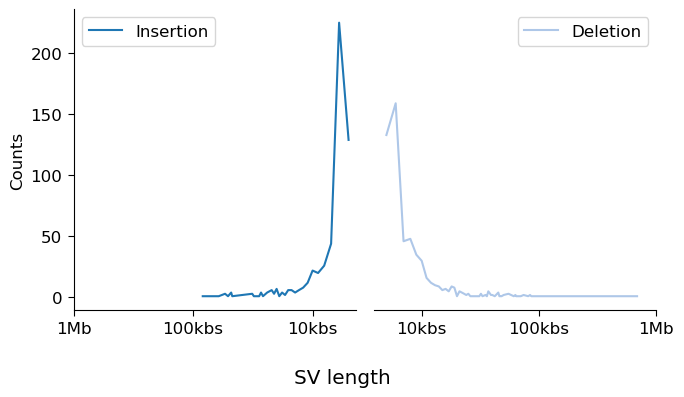

In [101]:
df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
bin_size = 1000
df['bin'] = (df['SVLEN'] // bin_size) * bin_size

insertion = df[df['SVTYPE'] == 'INS']
ins_counts = insertion['bin'].value_counts().sort_index()

deletion = df[df['SVTYPE'] == 'DEL']
del_counts = deletion['bin'].value_counts().sort_index()

xticks = np.logspace(4,6,3)
xlabels = ['10kbs', '100kbs', '1Mb']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
colors = [mcolors.to_hex(color) for color in colors]

ax1.plot(ins_counts.index, ins_counts.values, color=colors[0], label = 'Insertion')
ax2.plot(del_counts.index, del_counts.values, color=colors[1], label = 'Deletion')

ax1.legend()
ax2.legend()
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_ylabel('Counts')
ax1.set_xticks(xticks, xlabels)
# ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xticks(xticks, xlabels)
# ax2.set_yscale('log')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False if ax is ax2 else True)  # keep y-axis on leftmost
    ax.spines['bottom'].set_visible(True)

ax2.tick_params(labelleft=False)
ax2.tick_params(axis='y', which='both', length=0)

ax1.tick_params(axis='x', which='minor', length=0)
ax2.tick_params(axis='x', which='minor', length=0)

fig.supxlabel('SV length')
plt.tight_layout()
plt.show()

### Eichler test multi-allelic sites

In [10]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 396
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries)
haps = results['model_ary'][-1].haps

outputs = {}
outputs['chromosome'] = chrom
outputs['g_start'] = sv_start
outputs['start'] = start
outputs['end'] = end
outputs['length'] = L
outputs['svtype'] = svtype
outputs['means'] = means
outputs['variances'] = variances
outputs['coverage'] = coverage
outputs['info'] = info
outputs['freq'] = freq
outputs['concordance'] = concordance
outputs['haps'] = haps
outputs['probs'] = np.round(probs, 4)
outputs['genotypes'] = genotypes

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = True)
# plt.show()
# # plot_sv_heatmap(means, variances, coverage, samples, results)
# # plt.show()
# plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
# plt.show()

------ Iteration 5 ------
Best loglikelihood: 77445.89429821976
------ Iteration 10 ------
Best loglikelihood: 77283.35630041792
------ Iteration 15 ------
Best loglikelihood: 77283.33538017952


KeyboardInterrupt: 

------ Iteration 5 ------
Best loglikelihood: 71808.81922976664
------ Iteration 10 ------
Best loglikelihood: 71808.81433281525
------ Iteration 15 ------
Best loglikelihood: 71808.80812795773
------ Iteration 20 ------
Best loglikelihood: 71808.80812795773
------ Iteration 25 ------
Best loglikelihood: 71808.80812795773
------ Iteration 30 ------
Best loglikelihood: 71808.80812795773
------ Iteration 35 ------
Best loglikelihood: 71808.80812795773
------ Iteration 40 ------
Best loglikelihood: 71808.80812795773
------ Iteration 45 ------
Best loglikelihood: 71808.80812795773
------ Iteration 50 ------
Best loglikelihood: 71808.80812795773
------ Iteration 55 ------
Best loglikelihood: 71808.80812795773
------ Iteration 60 ------
Best loglikelihood: 71808.80812795773
------ Iteration 65 ------
Best loglikelihood: 71808.80812795773
------ Iteration 70 ------
Best loglikelihood: 71808.80812795773
------ Iteration 75 ------
Best loglikelihood: 71808.80812795773
------ Iteration 80 ------

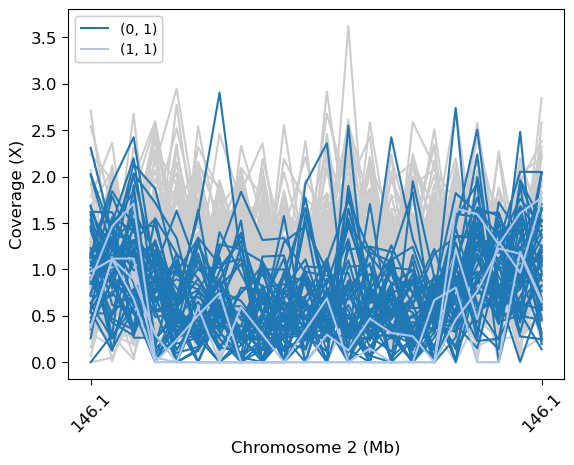

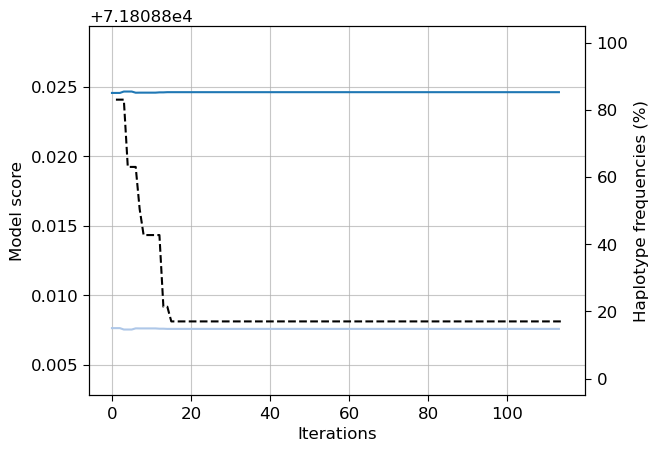

In [188]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 1175
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)


f1 = estimate_maf(means, variances, coverage, svtype)
plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries)
haps = results['model_ary'][-1].haps

outputs = {}
outputs['chromosome'] = chrom
outputs['g_start'] = sv_start
outputs['start'] = start
outputs['end'] = end
outputs['length'] = L
outputs['svtype'] = svtype
outputs['means'] = means
outputs['variances'] = variances
outputs['coverage'] = coverage
outputs['info'] = info
outputs['freq'] = freq
outputs['concordance'] = concordance
outputs['haps'] = haps
outputs['probs'] = np.round(probs, 4)
outputs['genotypes'] = genotypes

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)
# plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

In [22]:
cols = ['Chromosome', 'Start', 'End']

gr1 = target.iloc[:,:3]
gr1.columns = cols
gr1['123'] = 0
gr1 = pr.PyRanges(gr1)

insertions = np.where(df['SVTYPE'] == 'INS')[0]
df.loc[insertions, 'END'] = df.loc[insertions, 'POS'] + df.loc[insertions, 'SVLEN']

gr2 = df.iloc[:,:3]
gr2.columns = cols
gr2 = pr.PyRanges(gr2)

non_overlapping = gr1.subtract(gr2)
df3 = non_overlapping.df
df3

Chromosome      Start        End  123
0         chr1    9623989    9630469    0
1         chr1   78489056   78495526    0
2         chr1  103938232  103943510    0
3         chr1  105315155  105321219    0
4         chr1  116439354  116440937    0
..         ...        ...        ...  ...
272      chr22   28059914   28065996    0
273      chr22   38644316   38644446    0
274      chr22   38646826   38648357    0
275      chr22   38648722   38650690    0
276      chr22   46366929   46371355    0

[277 rows x 4 columns]

### Eichler before remove regions

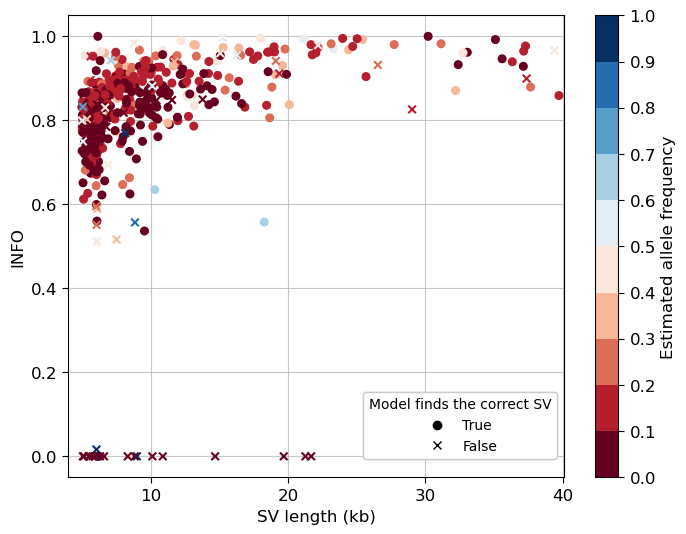

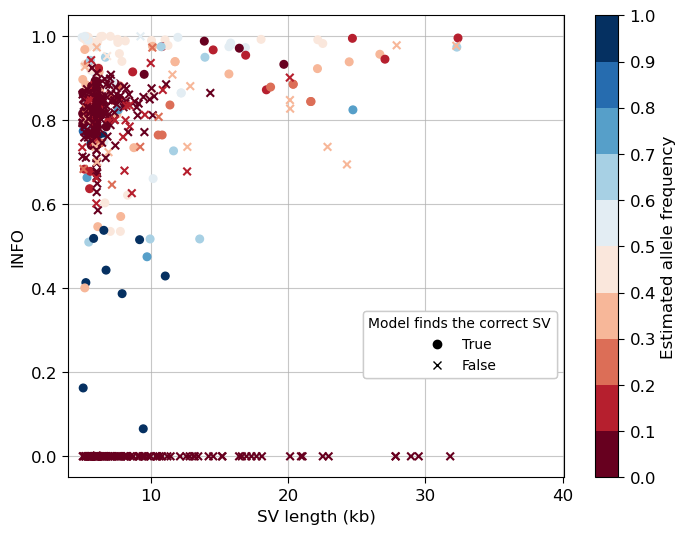

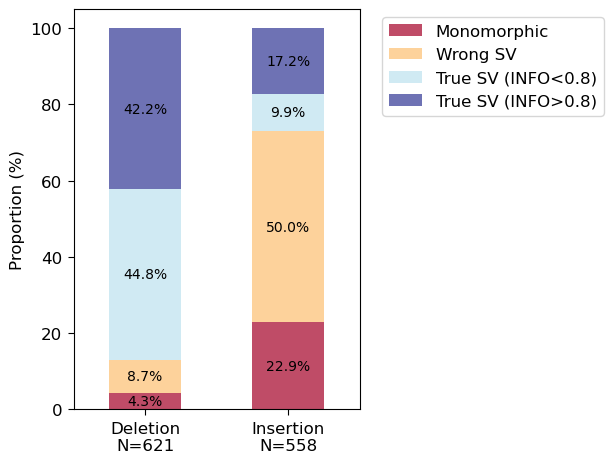

In [88]:
###### To Call SV
tmp = df1.copy()
tmp = tmp[tmp['SVTYPE'] == 'DEL']
# tmp = tmp[tmp['n_hap'] != 1]

# print(len(tmp))
# print((tmp['SVTYPE'] == 'INS').sum())
# print((tmp['n_hap'] == 1).sum())

cmap = plt.get_cmap('RdBu')
# bounds = np.arange(7)*10
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
ax.scatter(true['SVLEN'], true['max_info'], c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)

false = tmp[tmp['concordance'] == 0]
im = ax.scatter(false['SVLEN'], false['max_info'], c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.grid(alpha = 0.7, zorder = 1)
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('INFO')
plt.xlim(4000, 40100)

shape_handles = [
    Line2D([0], [0], marker = 'o', color='black', linestyle='', label='True'),
    Line2D([0], [0], marker = 'x', color='black', linestyle='', label='False')
]
legend2 = plt.legend(handles=shape_handles, title='Model finds the correct SV', 
                     prop={'size': 10}, framealpha=1, bbox_to_anchor = (1, 0.2))
legend2.get_title().set_fontsize(10)
plt.gca().add_artist(legend2)   
legend2.get_frame().set_zorder(2)
        
plt.show()

#####
tmp = df1.copy()
tmp = tmp[tmp['SVTYPE'] == 'INS']
# tmp = tmp[tmp['n_hap'] != 1]

# print(len(tmp))
# print((tmp['SVTYPE'] == 'INS').sum())
# print((tmp['n_hap'] == 1).sum())

cmap = plt.get_cmap('RdBu')
# bounds = np.arange(7)*10
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
ax.scatter(true['SVLEN'], true['max_info'], c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)

false = tmp[tmp['concordance'] == 0]
im = ax.scatter(false['SVLEN'], false['max_info'], c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')

plt.grid(alpha = 0.7, zorder = 1)
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('INFO')
plt.xlim(4000, 40100)

shape_handles = [
    Line2D([0], [0], marker = 'o', color='black', linestyle='', label='True'),
    Line2D([0], [0], marker = 'x', color='black', linestyle='', label='False')
]
legend2 = plt.legend(handles=shape_handles, title='Model finds the correct SV', 
                     prop={'size': 10}, framealpha=1, bbox_to_anchor = (0.58, 0.2))
legend2.get_title().set_fontsize(10)
plt.gca().add_artist(legend2)   
legend2.get_frame().set_zorder(2)

plt.show()

tmp =  df1.copy()
plot_sv_result_category(tmp)

### Eichler result

In [66]:
# df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
df = df[df['#CHROM'].isin(main_chrs)]
df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
df = df[(df['SVLEN'] > 5000) & ((df['POP_AFR_AF'] >= 0.05) | (df['PG_AFR_AF'] >= 0.05))]
df = df[['#CHROM', 'POS', 'END', 'SVTYPE', 'SVLEN','ID']].reset_index(drop = True)

x = lcwgsus.read_vcf('/well/band/users/rbx225/recyclable_files/eichler_sv/variants_freeze4_sv_insdel_alt.vcf.gz')
x = x[x['ID'].isin(df['ID'])].reset_index(drop = True)
df = pd.merge(df, x[['ID', 'ref', 'alt', 'INFO']], on = ['ID'])
df['TRF'] = df['INFO'].apply(lambda x: 1 if 'REF_TRF' in x else 0)
df['REF_SD'] = df['INFO'].apply(lambda x: 0 if 'REF_SD' not in x else float(re.search(r'REF_SD=([^;]+)', x).group(1)))

n_hap_ary = []
true_info_ary = []
concordance_ary = []
est_freq_ary = []
mq_ary = []
bad_alignment_region_ary = []
true_hap_idx_ary = []
second_info_ary = []
max_info_ary = []
max_maf_ary = []

for ix in range(len(df)):
    infile = f'results/nonahore/eichler/region{ix}/results.pickle'
    if os.path.exists(infile):
        data = read_pickle(infile)
        
        n_hap = len(data['haps'])
        n_hap_ary.append(n_hap)
        est_freq_ary.append(data['freq'])
        concordance_ary.append(data['concordance'])
        mq_ary.append(data['mean_mq'])
        bad_alignment_region_ary.append(check_low_mq(data['mq']))
        
        true_hap_idx = data['true_hap_idx']
        if true_hap_idx == -9:
            true_hap_idx_ary.append(-9)
            true_info_ary.append(0)
        else:
            true_hap_idx_ary.append(true_hap_idx)
            true_info_ary.append(data['info'][true_hap_idx])
            
        if n_hap == 1:
            max_info_ary.append(0)
            max_maf_ary.append(0)
            second_info_ary.append(0)
        else:
            max_info_idx = np.array(data['info'][1:]).argmax() + 1
            max_info_ary.append(data['info'][max_info_idx])
            max_maf_ary.append(data['freq'][max_info_idx])
            second_info_ary.append(data['info'][1])
    else:
        n_hap_ary.append(0)
        true_info_ary.append(0)
        est_freq_ary.append(0)     
        concordance_ary.append(0)
        mq_ary.append(0)
        bad_alignment_region_ary.append(0)
        true_hap_idx_ary.append(-1)
        max_info_ary.append(0)
        max_maf_ary.append(0)
        second_info_ary.append(0)
    
df['n_hap'] = n_hap_ary
df['freq'] = est_freq_ary
df['concordance'] = concordance_ary
df['mean_mq'] = mq_ary
df['contain_bad_alignment'] = bad_alignment_region_ary

df['true_hap_idx'] = true_hap_idx_ary
df['true_info'] = true_info_ary
df['max_info'] = max_info_ary
df['max_maf'] = max_maf_ary
df['second_info'] = second_info_ary

bed = pd.read_csv('data/bedgraph/GRCh38.autosomes.bed', sep = '\t', header = None)
bed.columns = ['chr', 'start', 'end']

def check_endchr(r, cutoff = 1e6):
    c = r['#CHROM']
    s = r['POS']
    endchr = bed[bed['chr'] == c]['end'].values[0]

    if s > cutoff and s < endchr - cutoff:
        r['is_endchr'] = False
    else:
        r['is_endchr'] = True
    return r
        
df1 = df.copy()
df1['is_endchr'] = False
df1 = df1.apply(check_endchr, axis = 1)
print_avg_concordance(df1)

DEL: 0.8695652173913043
INS: 0.27060931899641577


In [70]:
# tmp = df1.copy()
tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]

tmp = tmp[tmp['mean_mq'] > 10]
tmp = tmp[~((tmp['mean_mq'] > 55) & (tmp['SVTYPE'] == 'INS'))]
tmp = tmp[tmp['n_hap'] != 1]

print_avg_concordance(tmp)
print(len(tmp))

DEL: 0.9165217391304348
INS: 0.9069767441860465
618


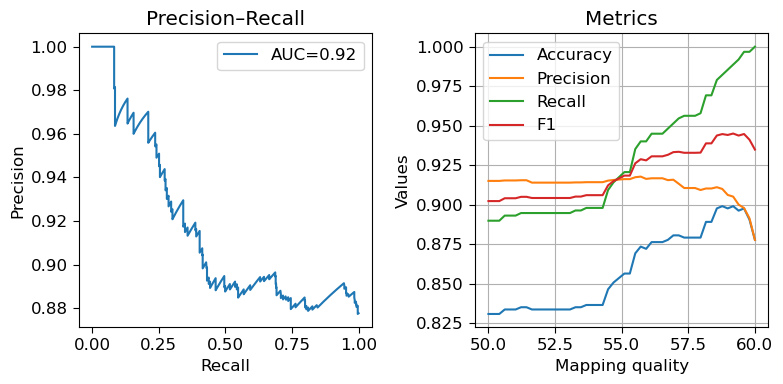

59.183673469387756

In [126]:
def analyze_threshold(INFO, is_correct, svtype):
    INFO = np.array(INFO)
    is_correct = np.array(is_correct)

    # ROC curve
    fpr, tpr, _ = roc_curve(is_correct, INFO)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(is_correct, INFO)
    pr_auc = auc(recall, precision)

    # Sweep thresholds
    thresholds = np.linspace(50, 60, 50)
#     thresholds = np.linspace(INFO.min(), INFO.max(), 50)
    accs, precs, recs, f1s, counts = [], [], [], [], []

    for t in thresholds:
#         keep = INFO >= t
#         keep = (INFO <= t) and (svtype)
        keep = ~((INFO >= t) & (svtype == 'INS'))

        if keep.sum() == 0:
            accs.append(np.nan)
            precs.append(np.nan)
            recs.append(np.nan)
            f1s.append(np.nan)
            counts.append(0)
            continue
        y_pred = keep.astype(int)  # 1 = kept, 0 = filtered
        accs.append(accuracy_score(is_correct, y_pred))
        precs.append(precision_score(is_correct, y_pred))
        recs.append(recall_score(is_correct, y_pred))
        f1s.append(f1_score(is_correct, y_pred))
        counts.append(keep.sum())

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    
    # PR
    axes[0].plot(recall, precision, label=f"AUC={pr_auc:.2f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision–Recall")
    axes[0].legend()

    # Metrics vs Threshold
    axes[1].plot(thresholds, accs, label="Accuracy")
    axes[1].plot(thresholds, precs, label="Precision")
    axes[1].plot(thresholds, recs, label="Recall")
    axes[1].plot(thresholds, f1s, label="F1")
    axes[1].set_xlabel("Mapping quality")
    axes[1].set_ylabel("Values")
    axes[1].set_title("Metrics")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    best_idx = np.nanargmax(f1s)
    best_threshold = thresholds[best_idx]
    return best_threshold
    
tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
# tmp = tmp[tmp['SVTYPE'] == 'INS']
tmp = tmp[tmp['mean_mq'] > 10]
# tmp = tmp[~((tmp['mean_mq'] > 59) & (tmp['SVTYPE'] == 'INS'))]
tmp = tmp[tmp['n_hap'] != 1]

INFO_example = tmp['mean_mq'].values
is_correct_example = tmp['concordance'].values
svtype = tmp['SVTYPE'].values

best_mq = analyze_threshold(INFO_example, is_correct_example, svtype)
best_mq

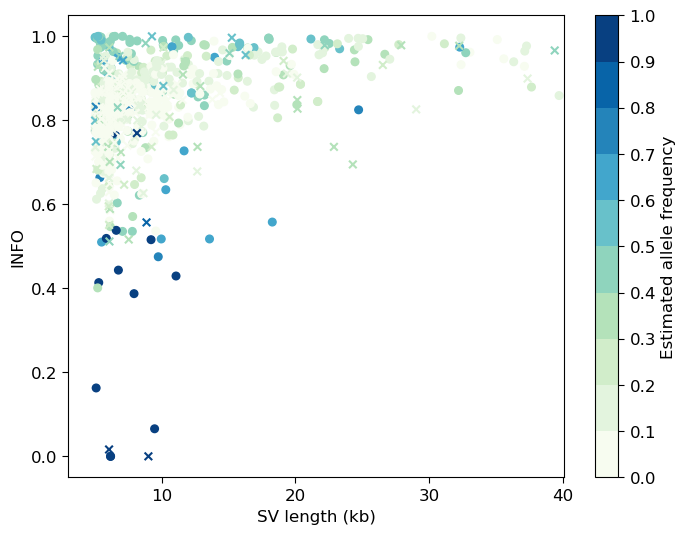

In [95]:
# All SV
cmap = plt.get_cmap('GnBu')
# bounds = np.arange(7)*10
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# tmp = df[df['SVTYPE'] != 'INS']
tmp = df1.copy()
tmp = tmp[tmp['n_hap'] != 1]


shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
ax.scatter(true['SVLEN'], true['max_info'], c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30)

false = tmp[tmp['concordance'] == 0]
im = ax.scatter(false['SVLEN'], false['max_info'], c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('INFO')
plt.xlim(3000, 40100)
plt.show()

tmp = df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
tmp = tmp[tmp['mean_mq'] > 10]
plot_sv_result_category(tmp)

704
102
33


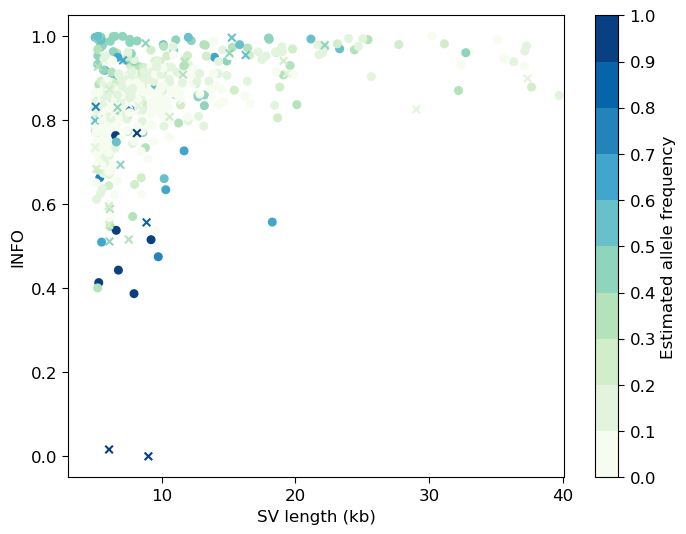

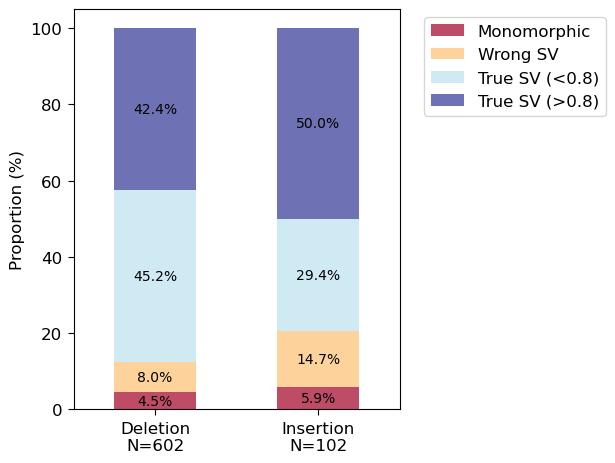

In [117]:
# To Call SV
tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
tmp = tmp[tmp['mean_mq'] > 10]
tmp = tmp[~((tmp['mean_mq'] > 59) & (tmp['SVTYPE'] == 'INS'))]
print(len(tmp))
print((tmp['SVTYPE'] == 'INS').sum())
print((tmp['n_hap'] == 1).sum())

cmap = plt.get_cmap('GnBu')
# bounds = np.arange(7)*10
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
tmp = tmp[tmp['mean_mq'] > 10]
tmp = tmp[~((tmp['mean_mq'] > 59) & (tmp['SVTYPE'] == 'INS'))]
tmp = tmp[tmp['n_hap'] != 1]

shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
ax.scatter(true['SVLEN'], true['max_info'], c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30)

false = tmp[tmp['concordance'] == 0]
im = ax.scatter(false['SVLEN'], false['max_info'], c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('INFO')
plt.xlim(3000, 40100)
plt.show()

tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
tmp = tmp[tmp['mean_mq'] > 10]
tmp = tmp[~((tmp['mean_mq'] > 59) & (tmp['SVTYPE'] == 'INS'))]
plot_sv_result_category(tmp)

#### Full Confusion Matrix

In [ ]:
def analyze_threshold(INFO, is_correct):
    INFO = np.array(INFO)
    is_correct = np.array(is_correct)

    # ROC curve
    fpr, tpr, _ = roc_curve(is_correct, INFO)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(is_correct, INFO)
    pr_auc = auc(recall, precision)

    # Sweep thresholds
    thresholds = np.linspace(50, 60, 50)
#     thresholds = np.linspace(INFO.min(), INFO.max(), 50)
    accs, precs, recs, f1s, counts = [], [], [], [], []

    for t in thresholds:
#         keep = INFO >= t
        keep = INFO <= t
        if keep.sum() == 0:
            accs.append(np.nan)
            precs.append(np.nan)
            recs.append(np.nan)
            f1s.append(np.nan)
            counts.append(0)
            continue
        y_pred = keep.astype(int)  # 1 = kept, 0 = filtered
        accs.append(accuracy_score(is_correct, y_pred))
        precs.append(precision_score(is_correct, y_pred))
        recs.append(recall_score(is_correct, y_pred))
        f1s.append(f1_score(is_correct, y_pred))
        counts.append(keep.sum())

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # ROC
    axes[0, 0].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
    axes[0, 0].plot([0, 1], [0, 1], 'k--')
    axes[0, 0].set_xlabel("False Positive Rate")
    axes[0, 0].set_ylabel("True Positive Rate")
    axes[0, 0].set_title("ROC Curve")
    axes[0, 0].legend()

    # PR
    axes[0, 1].plot(recall, precision, label=f"AUC={pr_auc:.2f}")
    axes[0, 1].set_xlabel("Recall")
    axes[0, 1].set_ylabel("Precision")
    axes[0, 1].set_title("Precision–Recall Curve")
    axes[0, 1].legend()

    # Metrics vs Threshold
    axes[1, 0].plot(thresholds, accs, label="Accuracy")
    axes[1, 0].plot(thresholds, precs, label="Precision")
    axes[1, 0].plot(thresholds, recs, label="Recall")
    axes[1, 0].plot(thresholds, f1s, label="F1")
    axes[1, 0].set_xlabel("Threshold")
    axes[1, 0].set_ylabel("Metric value")
    axes[1, 0].set_title("Metrics vs Threshold")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Calls kept vs Threshold
    axes[1, 1].plot(thresholds, counts, marker="o")
    axes[1, 1].set_xlabel("Threshold")
    axes[1, 1].set_ylabel("# Calls kept")
    axes[1, 1].set_title("Number of calls kept vs Threshold")
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    
tmp =  df1[~((df1['SVTYPE'] == 'INS') & (df1['TRF'] == 0))]
# tmp = tmp[tmp['SVTYPE'] == 'INS']
tmp = tmp[tmp['mean_mq'] > 10]
# tmp = tmp[~((tmp['mean_mq'] > 59) & (tmp['SVTYPE'] == 'INS'))]
tmp = tmp[tmp['n_hap'] != 1]

INFO_example = tmp['mean_mq'].values
is_correct_example = tmp['concordance'].values

analyze_threshold(INFO_example, is_correct_example)


#### ix = 67

In [141]:
df1.loc[67, :]

#CHROM                                                     chr11
POS                                                     93420970
END                                                     93427031
SVTYPE                                                       DEL
SVLEN                                                       6061
ID                                       chr11-93420971-DEL-6061
ref            TGAAAATGGCCATACCGGATGGCCGAATAGGAACAGCTCCGGTCTA...
alt                                                            T
INFO           ID=chr11-93420971-DEL-6061;VARTYPE=SV;SVTYPE=D...
TRF                                                            1
REF_SD                                                       0.0
n_hap                                                          2
info                                                         0.0
freq                                                         0.0
concordance                                                    0
is_endchr                

------ Iteration 5 ------
Best loglikelihood: 53131.94922853062
------ Iteration 10 ------
Best loglikelihood: 53099.90199369285
------ Iteration 15 ------
Best loglikelihood: 53099.90199369285
------ Iteration 20 ------
Best loglikelihood: 53099.90199369285
------ Iteration 25 ------
Best loglikelihood: 53099.90199369285
------ Iteration 30 ------
Best loglikelihood: 53099.90199369285
------ Iteration 35 ------
Best loglikelihood: 53099.90199369285
------ Iteration 40 ------
Best loglikelihood: 53099.90199369285
------ Iteration 45 ------
Best loglikelihood: 53099.90199369285
------ Iteration 50 ------
Best loglikelihood: 53099.90199369285
------ Iteration 55 ------
Best loglikelihood: 53099.90199369285
------ Iteration 60 ------
Best loglikelihood: 53099.90199369285
------ Iteration 65 ------
Best loglikelihood: 53099.90199369285
------ Iteration 70 ------
Best loglikelihood: 53099.90199369285
------ Iteration 75 ------
Best loglikelihood: 53099.90199369285
------ Iteration 80 ------

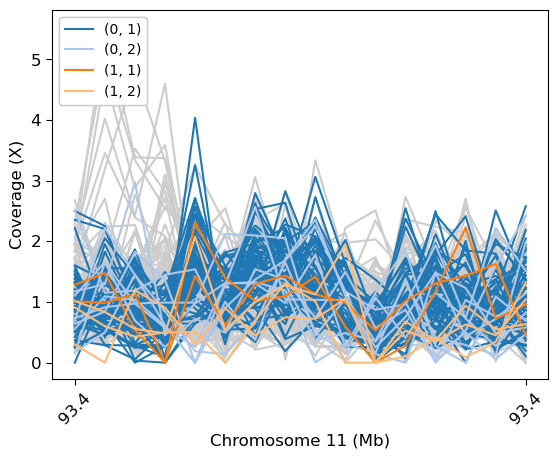

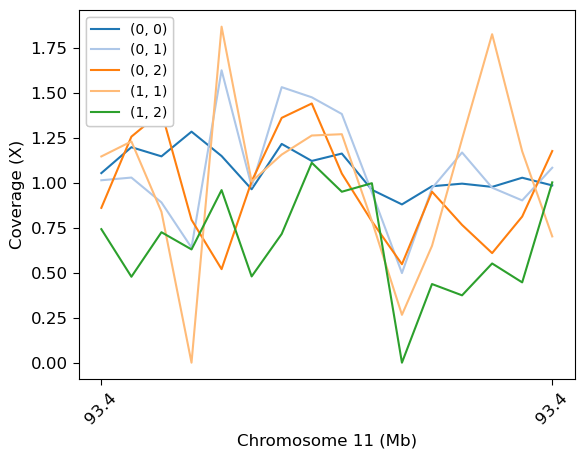

In [20]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 67
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

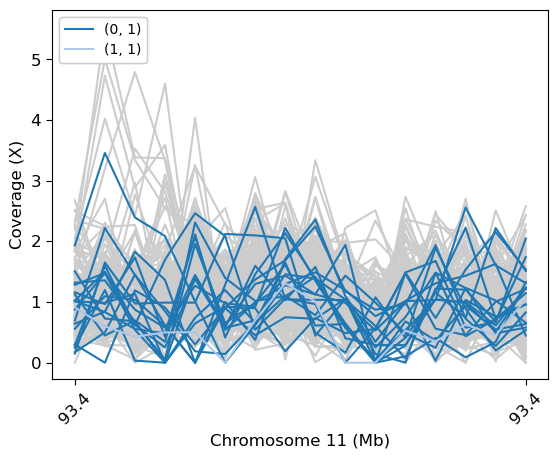

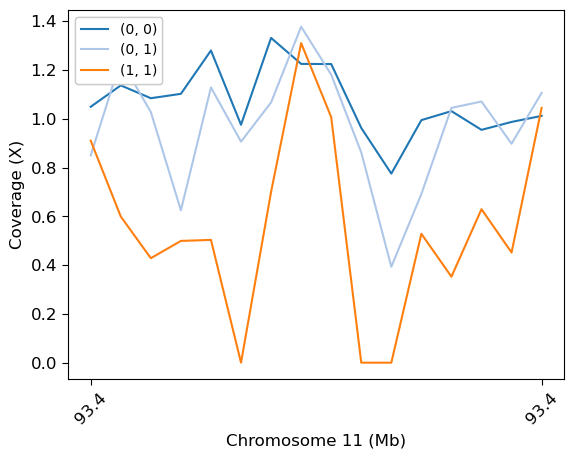

In [12]:
x = read_pickle('results/nonahore/eichler/region67/results.pickle')
x_calling_dict = call_sv_samples(samples, x['genotypes'])
plot_sv_coverage(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()

In [104]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
eichler_full[(eichler_full['#CHROM'] == 'chr11') & (eichler_full['POS'] >= 93400000) & (eichler_full['POS'] <= 93430000)]

#CHROM       POS       END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
15802  chr11  93420970  93427031    DEL   6061       0.85    0.909091
15803  chr11  93427016  93427017    INS   1750        NaN    0.045455

In [147]:
# eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
# indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
# eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
# eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
# cols = ['Chromosome', 'Start', 'End']
# eichler_full.columns = cols + eichler_full.columns[3:].tolist()
# eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

# chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
# with open(chunk_file, 'r') as file:
#     regions = json.load(file)

# bin_size = 1000

# manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
# ix = 67
# chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
# chromosome = int(chrom.replace('chr', ''))
# start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# flank = 1e5
# plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
# cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
# means, variances = normalise_by_flank2(cov, start, end, flank)
# samples, coverage = extract_target_cov(cov, start, end)


cov = cov[(cov['position'] >= 93420000) & (cov['position'] <= 93430000)]
cov

chromosome  position  bin_size     L  IDT0481:coverage  IDT0481:mean_mq  \
3420      chr11  93420000      1000  1000              1976         30.73130   
3421      chr11  93421000      1000  1000               795         17.82260   
3422      chr11  93422000      1000  1000              1375          1.75491   
3423      chr11  93423000      1000  1000              2176         20.39710   
3424      chr11  93424000      1000  1000              2033          1.14609   
3425      chr11  93425000      1000  1000              1603          1.13038   
3426      chr11  93426000      1000  1000              1345          6.85502   
3427      chr11  93427000      1000  1000              1282         51.51950   
3428      chr11  93428000      1000  1000               696         55.66090   
3429      chr11  93429000      1000  1000              1495         60.00000   
3430      chr11  93430000      1000  1000               856         60.00000   

      IDT0482:coverage  IDT0482:mean_mq  IDT0483:coverage  IDT0483:mean_mq  \
3420               624         47.41670              1203         34.26680   
3421              1214          6.29160              1422          8.78762   
3422              1821          0.00000              1884          2.66454   
3423              1812         13.25440              1967          7.86528   
3424               895          1.34078              1729          2.14344   
3425              1313          0.00000              1970          0.00000   
3426               449          0.00000               674          0.00000   
3427               302         48.00000               749         48.90250   
3428              1510         58.70000              1029         57.59380   
3429              1538         60.00000               966         60.00000   
3430               968         60.00000              1258         60.00000   

      ...  IDT0765:mean_mq  IDT0766:coverage  IDT0766:mean_mq  \
3420  ...         42.32320              1264        24.102100   
3421  ...         19.07640              1690         3.573960   
3422  ...          1.96113               890         0.000000   
3423  ...          3.29092              2153         6.270320   
3424  ...          1.39660              2281         0.171854   
3425  ...          0.00000              1669         0.000000   
3426  ...          0.00000               336         0.000000   
3427  ...         47.99020               638        42.286800   
3428  ...         58.79110              2567        58.351000   
3429  ...         60.00000              1339        60.000000   
3430  ...         60.00000              1263        60.000000   

      IDT0767:coverage  IDT0767:mean_mq  IDT0768:coverage  IDT0768:mean_mq  \
3420               680         30.68820               894         48.68340   
3421              1722          9.82114              1352          5.36095   
3422              1167          0.00000              1683          0.00000   
3423              2509          8.12475              2604         12.49190   
3424              2287          0.00000              1927          1.29891   
3425               771          0.00000              1041          0.00000   
3426               604          0.00000              1622          0.00000   
3427               849         45.15780                25          0.00000   
3428               613         58.20550              1201         55.72520   
3429               952         60.00000              2889         60.00000   
3430              1198         60.00000              2183         60.00000   

        N  total:coverage  total:mean_mq  
3420  210          246752      35.351200  
3421  210          298711       7.718810  
3422  210          228177       1.483920  
3423  210          307490       6.332490  
3424  210          293113       0.551937  
3425  210          286389       0.089239  
3426  210          224741       0.752965  
3427  210          172149      41.966000  
34

In [124]:
vcf = read_tabix('/well/band/users/rbx225/recyclable_files/eichler_sv/variants_freeze4_sv_insdel_alt.vcf.gz', 11, 93427016, 93427017)
bam = read_bam('data/bams/IDT0494.bam', 11, 93423000, 93425000)

In [139]:
scores = pd.DataFrame(np.zeros((len(bam), len(vcf))))

to_aligns = [vcf.loc[0, 'ref'], vcf.loc[1, 'alt']]

for i in range(len(vcf)):
    ref = pywfa.WavefrontAligner(to_aligns[i])
    for j in range(len(bam)):
        seq = bam.loc[j, 'sequence']
        result = ref(seq, clip_cigar=True, min_aligned_bases_left=10, min_aligned_bases_right=10)
        score = calculate_score_per_alignment(result.cigartuples)
        scores.loc[j, i] = score

scores

0      1
0    0.0 -616.0
1    0.0 -616.0
2   -4.0 -616.0
3    0.0 -616.0
4  -12.0 -616.0
5    0.0 -616.0
6  -44.0 -290.0
7   -8.0 -616.0
8    0.0 -616.0
9    0.0 -222.0
10  -4.0  -36.0
11   0.0  -24.0
12   0.0  -58.0
13  -4.0  -24.0
14   0.0  -22.0
15   0.0  -50.0
16 -22.0  -56.0

#### ix = 1164

In [177]:
df1.loc[1164,:].to_frame().T

#CHROM       POS       END SVTYPE  SVLEN                        ID  \
1164  chr18  14804559  14815446    DEL  10887  chr18-14804559-DEL-10887   

                                                    ref alt  \
1164  CGTTGGACCTTGCTCTGAGTAGCAAGATGAGAGACCTTTGTGGGAA...   C   

                                                   INFO TRF REF_SD n_hap info  \
1164  ID=chr18-14804559-DEL-10887;VARTYPE=SV;SVTYPE=...   1   0.98     1  0.0   

     freq concordance is_endchr  
1164  0.0           0     False

------ Iteration 5 ------
Best loglikelihood: 62914.13445451005
------ Iteration 10 ------
Best loglikelihood: 62914.10485584308
------ Iteration 15 ------
Best loglikelihood: 62914.10485584308
------ Iteration 20 ------
Best loglikelihood: 62914.10485584308
------ Iteration 25 ------
Best loglikelihood: 62914.10485584308
------ Iteration 30 ------
Best loglikelihood: 62914.10485584308
------ Iteration 35 ------
Best loglikelihood: 62914.09921254094
------ Iteration 40 ------
Best loglikelihood: 62914.09921254094
------ Iteration 45 ------
Best loglikelihood: 62914.09921254094
------ Iteration 50 ------
Best loglikelihood: 62914.09921254094
------ Iteration 55 ------
Best loglikelihood: 62914.09921254094
------ Iteration 60 ------
Best loglikelihood: 62914.09921254094
------ Iteration 65 ------
Best loglikelihood: 62914.09921254094
------ Iteration 70 ------
Best loglikelihood: 62914.09921254094
------ Iteration 75 ------
Best loglikelihood: 62914.081696200476
------ Iteration 80 -----

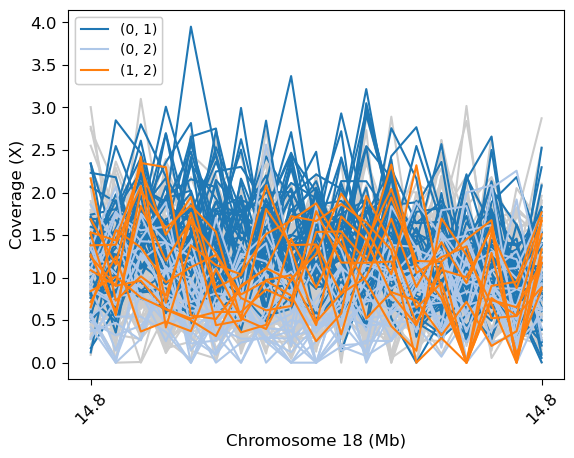

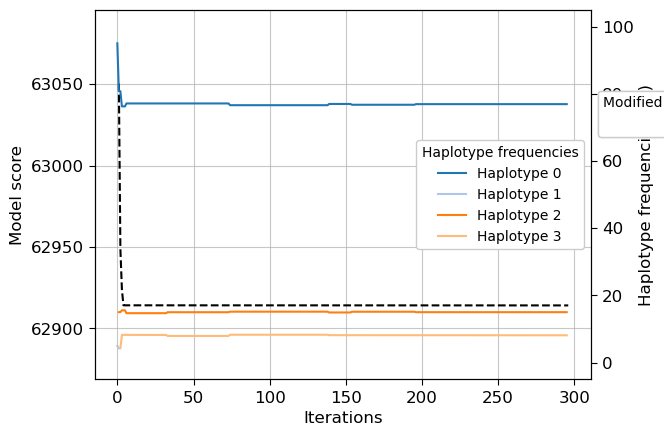

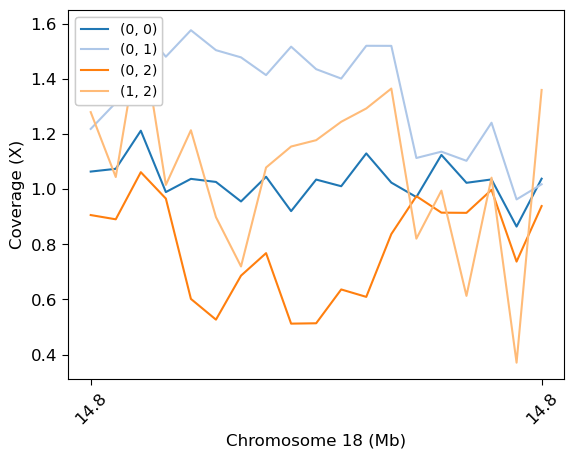

In [150]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 1164
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance, true_hap_idx = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

In [189]:
vcf = read_tabix('/well/band/users/rbx225/recyclable_files/eichler_sv/variants_freeze4_sv_insdel_alt.vcf.gz', 18, 1840278, 1840279)
bam = read_bam('data/bams/IDT0485.bam', 18, 14801000, 14812000)
bam = bam[bam['map_quality'] == '0']


In [193]:
bam.loc[1, 'col11']

'XA:Z:chr18,+14812181,151M,0;chr21,-13423962,151M,4;'

In [ ]:
scores = pd.DataFrame(np.zeros((len(bam), len(vcf))))

to_aligns = [vcf.loc[0, 'ref'], vcf.loc[1, 'alt']]

for i in range(len(vcf)):
    ref = pywfa.WavefrontAligner(to_aligns[i])
    for j in range(len(bam)):
        seq = bam.loc[j, 'sequence']
        result = ref(seq, clip_cigar=True, min_aligned_bases_left=10, min_aligned_bases_right=10)
        score = calculate_score_per_alignment(result.cigartuples)
        scores.loc[j, i] = score

scores

In [9]:
eichler_full[(eichler_full['Chromosome'] == 'chr18') & (eichler_full['Start'] <= 5e7) 
             & (eichler_full['SVLEN'] >= 5000) & (eichler_full['SVTYPE'] == 'INS')]

Chromosome     Start       End SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
39873      chr18   1817744   1862812    INS  22534       0.37    0.545455
40118      chr18  10621149  10633231    INS   6041       0.07    0.047619
40201      chr18  12485025  12497479    INS   6227       0.24    0.500000
40360      chr18  15089200  15101296    INS   6048        NaN    0.400000
40419      chr18  22545031  22556419    INS   5694       0.82    0.818182
40724      chr18  36743789  36755835    INS   6023       0.00    0.045455
40827      chr18  42310766  42323174    INS   6204       0.00    0.045455

In [182]:
# eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
# indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
# eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
# eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
# cols = ['Chromosome', 'Start', 'End']
# eichler_full.columns = cols + eichler_full.columns[3:].tolist()
# eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

# chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
# with open(chunk_file, 'r') as file:
#     regions = json.load(file)

# bin_size = 1000

# manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
# ix = 1164
# chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
# chromosome = int(chrom.replace('chr', ''))
# start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# flank = 1e5
# plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

# cov = load_region_files(regions, chromosome, start, end, flank = flank)
# cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
# means, variances = normalise_by_flank2(cov, start, end, flank)
# samples, coverage = extract_target_cov(cov, start, end)
tmp['IDT0485:coverage']

4801     976
4802    1582
4803    2143
4804     873
4805    1976
4806    1818
4807    1881
4808    1662
4809    1551
4810    1608
4811    1739
4812    1739
4813    1156
4814    1238
4815     950
4816    2109
4817    1532
4818    1483
4819    1441
Name: IDT0485:coverage, dtype: int64

#### Some random regions

In [104]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 460
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

# results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

# probs, genotypes = results['probs'], results['genotypes']
# info, freq, concordance = evaluate_real_model2(results, plausible_boundaries, svtype)
# haps = results['model_ary'][-1].haps

# best_model = results['model_ary'][-1]
# calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
# plt.show()

### Look at specific regions

In [9]:
df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
tmp = df[df['#CHROM'] == 'chr19']
tmp = tmp[(tmp['POS'] >= 54273812) & (tmp['POS'] <= 54638022)]
tmp

#CHROM       POS       END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
32  chr19  54297003  54297004    INS   6759       0.82         1.0

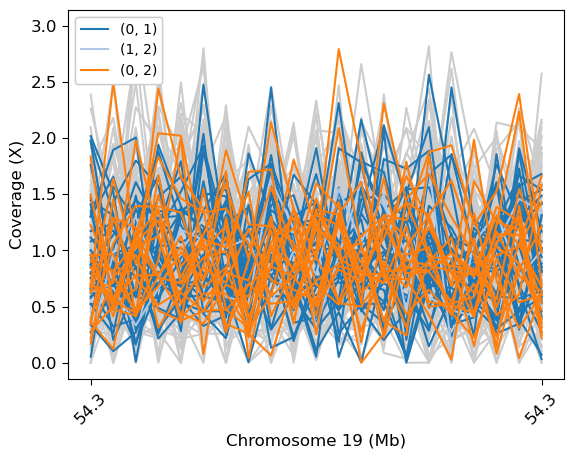

In [12]:
cov = data['coverage']
chromosome = 19
start = 54290000
end = 54310000
flank = end-start

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')
calling_dict = call_sv_samples(samples, data['genotypes'])
plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

## denovo

### Simulation

Text(0, 0.5, 'Estimated SV allele frequency')

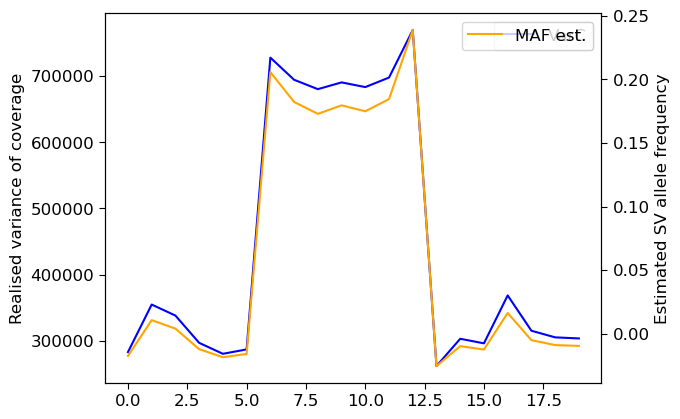

In [174]:
l = 20
f1 = 0.2
N = 210
v = 100

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0

coverage = pd.read_csv(f'results/nonahore/simulate/plausibility/rep0/{v}-{l}-{f1}-coverage.txt', sep = '\t', header = None).to_numpy()
this_vars = (coverage.var(axis = 1))

tmp = coverage[h2 != 0, :]
means = tmp.mean(axis = 0)/2
variances = tmp.var(axis = 0, ddof = 1)/2

EM = means.mean()
DM = means.var(ddof = 1)
V = variances.mean()
EX = 2-2*f1
DX = 2*f1*(1-f1)

A = 2*DM - 2*(EM**2)
B = 2*(EM**2-V-4*DM+DM)
C = 4*DM + 2*V-this_vars

delta = B**2-4*A*C
sqrt_term = np.sqrt(delta)
f1 = (-B + sqrt_term) / (2*A)
f2 = (-B - sqrt_term) / (2*A)

fig, ax1 = plt.subplots()

ax1.plot(this_vars, color = 'b', label = 'VarC')
ax1.legend()
ax1.set_ylabel('Realised variance of coverage')
ax2 = ax1.twinx()
ax2.plot(f1, color = 'orange', label = 'MAF est.')
ax2.legend()
ax2.set_ylabel('Estimated SV allele frequency')

### Real

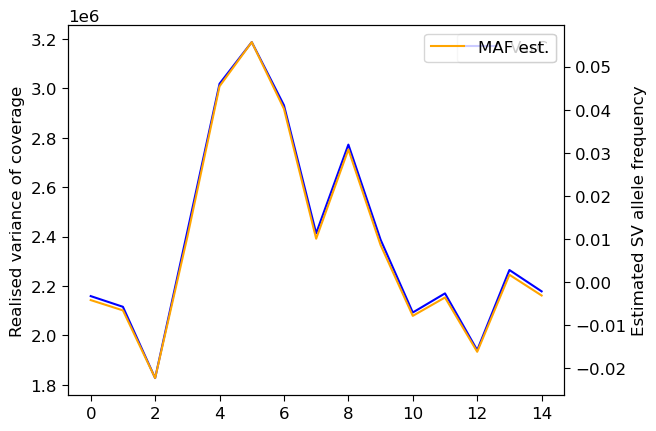

In [230]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 5000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start
svtype = 'INS'

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov = deresolute_windows(cov, bin_size)

means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)

this_vars = coverage.var(axis = 1)

plot_maf(coverage, f1)

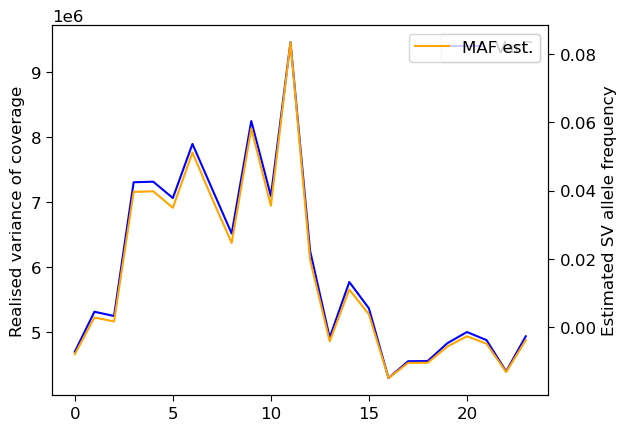

In [265]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 10000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start
svtype = 'DEL'

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov = deresolute_windows(cov, bin_size)

means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)

this_vars = coverage.var(axis = 1)

plot_maf(coverage, f1)

### denovo detection generate manifest

Text(0, 0.5, 'per-bin variance')

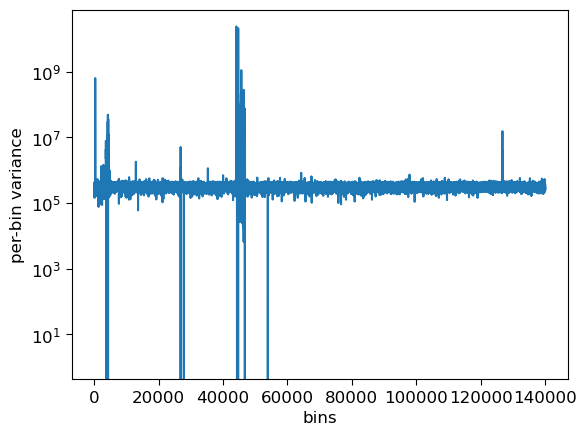

In [148]:
plt.plot(cov.var(axis = 1))
plt.yscale('log')
plt.xlabel('bins')
plt.ylabel('per-bin variance')

In [323]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

crit_ary = []
for c in range(1,23):
    this_chr_fstart = regions[f'{c}']['start'][0]
    this_chr_fend = regions[f'{c}']['end'][-1]

    cov = load_region_files(regions, c, this_chr_fstart, this_chr_fend)
    cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

    means = cov.iloc[:,1:-1].mean(axis = 0).values
    coverage = cov.iloc[:,1:-1].to_numpy()

    variances = 300000*np.ones(coverage.shape[1])

    f1 = estimate_maf(means, variances, coverage, 'DEL')
    f2 = estimate_maf(means, variances, coverage, 'INS')

    means = coverage.mean(axis = 1)
    crit1 = find_intervals(means, f1)
    crit1['SVTYPE'] = 'DEL'
    crit2 = find_intervals(means, f2)
    crit2['SVTYPE'] = 'INS'
    crit = pd.concat([crit1, crit2]).reset_index(drop = True)
    crit['#CHROM'] = c
    crit = crit[['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
    crit_ary.append(crit)

df = pd.concat(crit_ary)
df['#CHROM'] = 'chr' + df['#CHROM'].astype(str)
df['POS'] = df['POS']*bin_size
# df.to_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t', index = None)

### denovo result

In [403]:
df = pd.read_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t')

n_hap_ary = []
info_ary = []
est_freq_ary = []

for ix in range(len(df)):
    infile = f'results/nonahore/denovo/region{ix}/results.pickle'
    if os.path.exists(infile):
        data = read_pickle(infile)
        n_hap_ary.append(len(data['haps']))
        info_ary.append(data['info'])
        est_freq_ary.append(data['freq'])
    else:
        n_hap_ary.append(0)
        info_ary.append(0)
        est_freq_ary.append(0)        
    
df['n_hap'] = n_hap_ary
df['info'] = info_ary
df['freq'] = est_freq_ary
df['SVLEN'] = df['SVLEN']*1000

In [417]:
eichler_df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
df1 = eichler_df[['#CHROM', 'POS', 'SVLEN']]
df1['END'] = df1['POS'] + df1['SVLEN']
df1 = df1[['#CHROM', 'POS', 'END']]
df1.columns = ['chr', 'start', 'end']

df2 = pd.read_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t')
df2['END'] = df2['POS'] + df2['SVLEN']*1000
df2 = df2[['#CHROM', 'POS', 'END']]
df2.columns = ['chr', 'start', 'end']

df1 = df1.sort_values(['chr', 'start']).reset_index(drop=True)
df2 = df2.sort_values(['chr', 'start']).reset_index(drop=True)

# Count overlaps
count = 0
for i, row1 in df1.iterrows():
    # Subset df2 on same chromosome
    sub = df2[df2['chr'] == row1['chr']]
    
    # Check overlap condition: start1 < end2 and end1 > start2
    overlaps = sub[
        (row1['start'] < sub['end']) & 
        (row1['end'] > sub['start'])
    ]
    
    count += len(overlaps)

## mappability

In [3]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)
    
bin_size = 1000

df1 = parse_nonahore_result1()
df2 = parse_nonahore_result2()
# df3 = parse_nonahore_result3()

df1['callable_windows'] = df2['callable_windows']
df1['mean_ratio'] = df2['mean_ratio']
df1

#CHROM        POS        END SVTYPE  SVLEN                        ID  \
0      chr8  125582877  125588890    DEL   6013   chr8-125582878-DEL-6013   
1      chr5   58384165   58390274    DEL   6109    chr5-58384166-DEL-6109   
2     chr17   72880950   72880951    INS   8066   chr17-72880951-INS-8066   
3     chr17   72859877   72859878    INS   6353   chr17-72859878-INS-6353   
4      chr3   47784344   47784345    INS   8154    chr3-47784345-INS-8154   
...     ...        ...        ...    ...    ...                       ...   
1174   chr2  143253209  143253210    INS   6066   chr2-143253210-INS-6066   
1175   chr2  146105051  146119294    DEL  14243  chr2-146105052-DEL-14243   
1176   chr2  195227939  195227940    INS   5659   chr2-195227939-INS-5659   
1177   chr2  226090355  226097389    DEL   7034   chr2-226090356-DEL-7034   
1178   chr2  229476839  229476840    INS   6030   chr2-229476840-INS-6030   

                                                    ref  \
0     ACACTCACAGAGCGTGAGCGACGCAGAAGACGGTGATTTCTGCATT...   
1     CAAAAAACACGGAGGAGGAGCCAAGATGGCCGAATAGGAACAGCTC...   
2                                                     G   
3                                                     T   
4                                                     A   
...                                                 ...   
1174                                                  T   
1175  TGTAACTTAGATACTATGATGTAAAGTTACAGATACCTAAATACTA...   
1176                                                  T   
1177  CTTGTCGCCCAGGCCGGAGTGCAATGGCGTGATCTTGGCTCACTGG...   
1178                                                  C   

                                                    alt  \
0                                                     A   
1                                                     C   
2     GGATTACAGGCGTGAGCCACTGCGGCCGGCCCAGATAGGTGGCATT...   
3     TCTTGGGAGGCTGAGGCAGGAGAATTGCCTGAACCCAGGAGGCAGA...   
4     AGATCATGAGGTCAGGAGATCGAGACCATCCTGGCTAACACGGTGA...   
...                                                 ...   
1174  TAAAAAGTTTGATGGAGAGGGGAGGAGCCAAGATGGCCGAATAGGA...   
1175                                                  T   
1176  TACAAGAAAAAAACAAACAACCCCATCAAAAAGTGGGCGAAGGACA...   
1177                                                  C   
1178  CAAAAGGGGGGAGGAGCCAAGATGGCCGAATAGGAACAGCTCCGGT...   

                                                   INFO  TRF  ...  \
0     ID=chr8-125582878-DEL-6013;VARTYPE=SV;SVTYPE=D...    1  ...   
1     ID=chr5-58384166-DEL-6109;VARTYPE=SV;SVTYPE=DE...    1  ...   
2     ID=chr17-72880951-INS-8066;VARTYPE=SV;SVTYPE=I...    0  ...   
3     ID=chr17-72859878-INS-6353;VARTYPE=SV;SVTYPE=I...    0  ...   
4     ID=chr3-47784345-INS-8154;VARTYPE=SV;SVTYPE=IN...    0  ...   
...                                                 ...  ...  ...   
1174  ID=chr2-143253210-INS-6066;VARTYPE=SV;SVTYPE=I...    0  ...   
1175  ID=chr2-146105052-DEL-14243;VARTYPE=SV;SVTYPE=...    1  ...   
1176  ID=chr2-195227939-INS-5659;VARTYPE=SV;SVTYPE=I...    0  ...   
1177  ID=chr2-226090356-DEL-7034;VARTYPE=SV;SVTYPE=D...    0  ...   
1178  ID=chr2-229476840-INS-6030;VARTYPE=SV;SVTYPE=I...    0  ...   

      concordance    mean_mq  contain_bad_alignment  true_hap_idx  true_info  \
0               1  34.848440                   True             3   0.795641   
1               1  34.849835                   True             3   0.801781   
2               0  59.906704                  False            -9   0.000000   
3               0  59.930790                  False            -9   0.000000   
4               0  59.801467                  False            -9   0.000000   
...           ...        ...                    ...           ...        ...   
1174            0  59.968380                  False            -9   0.000000   
1175            1  59.977836                  False             2   0.720096   
1176            0  54.131832                  False            -9   0.000000   
1177            1  59.968573     

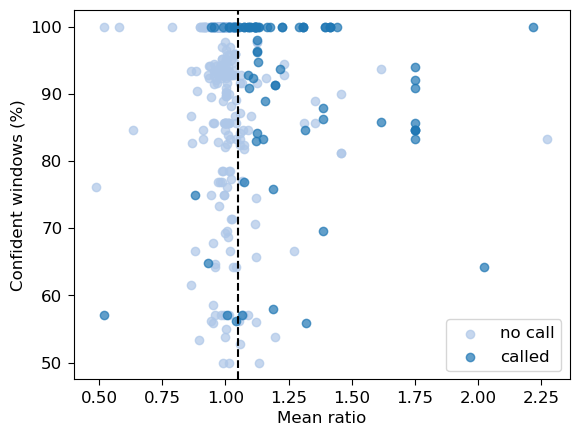

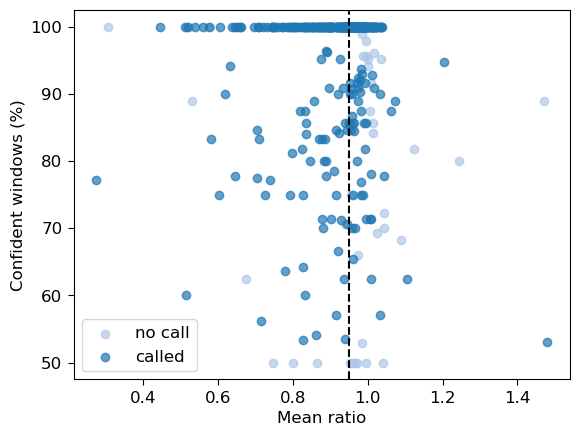

In [68]:
tmp = df2[df2['SVTYPE'] == 'INS']
# tmp = tmp[tmp['mean_ratio'] < 2]
tmp = tmp[tmp['callable_windows'] >= 0.5]

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:3]
colors = [mcolors.to_hex(c) for c in colors]

false = tmp[tmp['concordance'] == 0]
plt.scatter(false['mean_ratio'], false['callable_windows']*100, c = colors[1], alpha = 0.7, label = 'no call')
true = tmp[tmp['concordance'] == 1]
plt.scatter(true['mean_ratio'], true['callable_windows']*100, c = colors[0], alpha = 0.7, label = 'called')

plt.axvline(x = 1.05, ls = '--', color = 'black')
plt.legend(loc = 'lower right')
plt.xlabel('Mean ratio')
plt.ylabel('Confident windows (%)')
plt.show()

tmp = df2[df2['SVTYPE'] == 'DEL']
tmp = tmp[tmp['callable_windows'] >= 0.5]

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:3]
colors = [mcolors.to_hex(c) for c in colors]

false = tmp[tmp['concordance'] == 0]
plt.scatter(false['mean_ratio'], false['callable_windows']*100, c = colors[1], alpha = 0.7, label = 'no call')
true = tmp[tmp['concordance'] == 1]
plt.scatter(true['mean_ratio'], true['callable_windows']*100, c = colors[0], alpha = 0.7, label = 'called')

plt.axvline(x = 0.95, ls = '--', color = 'black')
plt.legend(loc = 'lower left')
plt.xlabel('Mean ratio')
plt.ylabel('Confident windows (%)')
plt.show()

In [70]:
tmp = df2.copy()
# tmp = tmp[tmp['to_call']]
tmp = tmp[tmp['callable_windows'] >= 0.5]

diff = 0.05
tmp =  tmp[((tmp['SVTYPE'] == 'INS') & (tmp['mean_ratio'] >= 1+diff)) | 
           ((tmp['SVTYPE'] == 'DEL') & (tmp['mean_ratio'] <= 1-diff))]

tmp = tmp[tmp['n_hap'] != 1]

print_avg_concordance(tmp)
print(len(tmp))

# plot_sv_result_category(tmp)

DEL: 0.9536082474226805
INS: 0.7411764705882353
279


In [101]:
df2[(df2['SVTYPE'] == 'DEL') & (df2['concordance'] == 0) & (df2['callable_windows'] > 0.9) & (df2['mean_ratio'] < 0.95)]

#CHROM        POS        END SVTYPE  SVLEN                       ID  \
220    chr6   32486909   32510887    DEL  23978  chr6-32486909-DEL-23978   
460    chr3   93854841   93863842    DEL   9001   chr3-93854842-DEL-9001   
642    chr8   86176019   86181514    DEL   5495   chr8-86176020-DEL-5495   
919    chr4  189270446  189279308    DEL   8862  chr4-189270447-DEL-8862   
969   chr20   26149873   26157404    DEL   7531  chr20-26149874-DEL-7531   
1124  chr16   34719493   34727636    DEL   8143  chr16-34719494-DEL-8143   

                                                    ref alt  \
220   TTAAAAAACCTGTTTTCAAACTTGTATTAAAAAGATATTTCTGCAA...   T   
460   CTCTGTTTTTCTTTTAACTATGAATTGTATCTTTAAATCCTTCCTT...   C   
642   GTTGCCAAACTGCATTACAGAACCAAGCCTTAAATTCCTTCTGATT...   G   
919   AGTTGCTTCTTATGGATGAACAAAGAAAATATTTTCTTGAGATGGA...   A   
969   AAGCCATTTTAGGATAAAAGAACGTTTCTCAGAACTATCACTGTAC...   A   
1124  TATAATGATTCCATTCGATTTCGTTCAATGTTGATTCCATTCAATT...   T   

                                                   INFO  TRF  ...    mean_mq  \
220   ID=chr6-32486909-DEL-23978;VARTYPE=SV;SVTYPE=D...    1  ...  54.299996   
460   ID=chr3-93854842-DEL-9001;VARTYPE=SV;SVTYPE=DE...    1  ...  59.975990   
642   ID=chr8-86176020-DEL-5495;VARTYPE=SV;SVTYPE=DE...    0  ...  59.995033   
919   ID=chr4-189270447-DEL-8862;VARTYPE=SV;SVTYPE=D...    1  ...  57.843090   
969   ID=chr20-26149874-DEL-7531;VARTYPE=SV;SVTYPE=D...    0  ...  59.092122   
1124  ID=chr16-34719494-DEL-8143;VARTYPE=SV;SVTYPE=D...    1  ...  58.876011   

     contain_bad_alignment  true_hap_idx  true_info  max_info   max_maf  \
220                  False            -9        0.0  0.998601  0.154262   
460                  False            -9        0.0  0.000006  0.990000   
642                  False            -9        0.0  0.000000  0.000000   
919                  False            -9        0.0  0.544228  0.843236   
969                  False            -9        0.0  0.492786  0.343421   
1124                 False            -9        0.0  0.804414  0.989993   

      second_info  to_call  callable_windows  mean_ratio  
220      0.960911     True               1.0    0.579200  
460      0.000006     True               1.0    0.306666  
642      0.000000     True               1.0    0.655691  
919      0.544228     True               1.0    0.801384  
969      0.492786     True               1.0    0.780507  
1124     0.804414     True               1.0    0.516992  

[6 rows x 23 columns]

In [31]:
mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
ix = 460

eichler_full = parse_eichler_full()
c = df.loc[ix, '#CHROM'].replace('chr', '')
s, e = find_eichler_region(ix, eichler_full)
tsv = read_bed_tabix(mapp, c, s, e)
metrics = calculate_mappability_per_bin(tsv, s, e)

cov = load_region_files(regions, c, s, e, flank = 1e6)
metrics = pd.merge(metrics, cov[['position', 'total:mean_mq']], on = ['position'])

to_call, include_bins = assess_bins(metrics)



# cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
# plot_mappability(tsv)

#### ix = 846

------ Iteration 5 ------
Best loglikelihood: 62593.979447826285
------ Iteration 10 ------
Best loglikelihood: 62586.17323475809
------ Iteration 15 ------
Best loglikelihood: 62584.25903074166
------ Iteration 20 ------
Best loglikelihood: 62583.45917583918
------ Iteration 25 ------
Best loglikelihood: 62583.45917583918
------ Iteration 30 ------
Best loglikelihood: 62583.45917583918
------ Iteration 35 ------
Best loglikelihood: 62146.485669771624
------ Iteration 40 ------
Best loglikelihood: 61913.7639619183
------ Iteration 45 ------
Best loglikelihood: 61913.34444235613
------ Iteration 50 ------
Best loglikelihood: 61913.34444235613
------ Iteration 55 ------
Best loglikelihood: 61913.34444235613
------ Iteration 60 ------
Best loglikelihood: 61913.34444235613
------ Iteration 65 ------
Best loglikelihood: 61913.34444235613
------ Iteration 70 ------
Best loglikelihood: 61913.34444235613
------ Iteration 75 ------
Best loglikelihood: 61913.34444235613
------ Iteration 80 -----

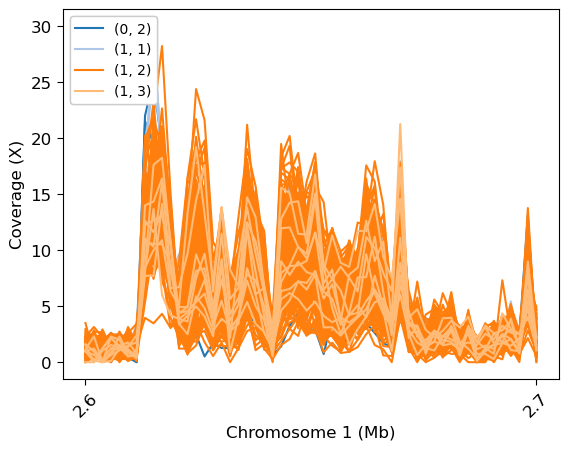

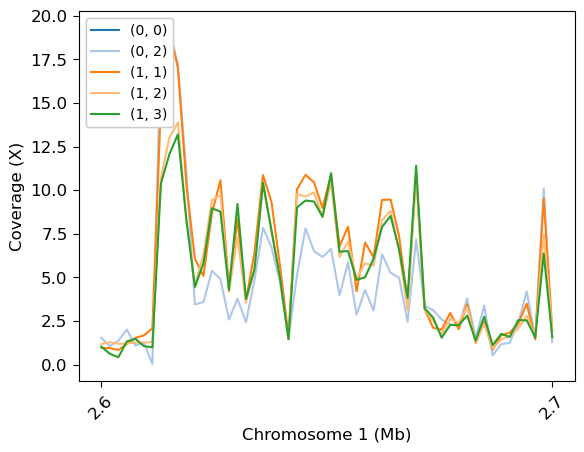

In [161]:
eichler_full = parse_eichler_full()

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 576
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# start, end = delineate_region3(chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)
metrics = calculate_mappability_per_bin(tsv, start, end)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
metrics = pd.merge(metrics, cov[['position', 'total:mean_mq']], on = ['position'])
to_call, include_bins = assess_bins(metrics, plausible_boundaries)
n_bins = len(metrics)

tmp = cov[(cov['position'] >= start) & (cov['position'] <= end)]
mq = tmp['total:mean_mq'].to_numpy()
mean_mq = tmp['total:mean_mq'].mean()

cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank3(cov, chromosome, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

flanking_regions = cov[(cov['position'] >= start - flank) & (cov['position'] <= end + flank)]
flanking_regions['mean'] = flanking_regions.iloc[:,1:-1].mean(axis = 1)
flanking_regions = flanking_regions[['position', 'mean']]
f1 = flanking_regions[(flanking_regions['position'] >= start) & (flanking_regions['position'] < end)]['mean'].mean()
f2 = flanking_regions[(flanking_regions['position'] < start) | (flanking_regions['position'] >= end)]['mean'].mean()
mean_ratio = f1/f2

coverage = coverage[include_bins, :]
results = nonahore(means, variances, coverage, n_recomb = 200, n_iter = 100, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance, true_hap_idx = evaluate_real_model3(results, plausible_boundaries, svtype, include_bins, n_bins)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

## Nonahore DEL final result

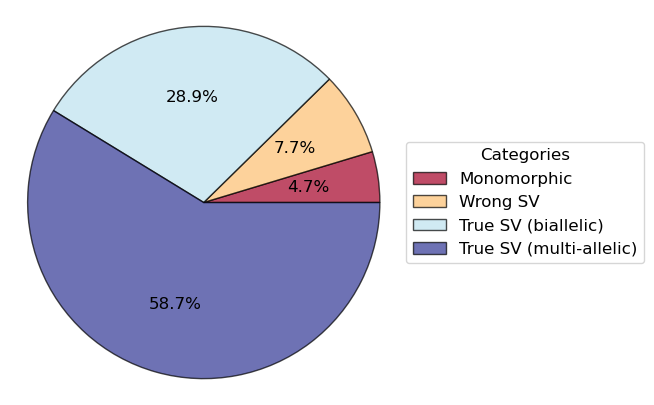

In [131]:
df2 = parse_nonahore_result2()
df2 = df2[df2['to_call']]
sv_cats = calculate_sv_result_category2(df2)
plot_sv_category_pie(sv_cats)

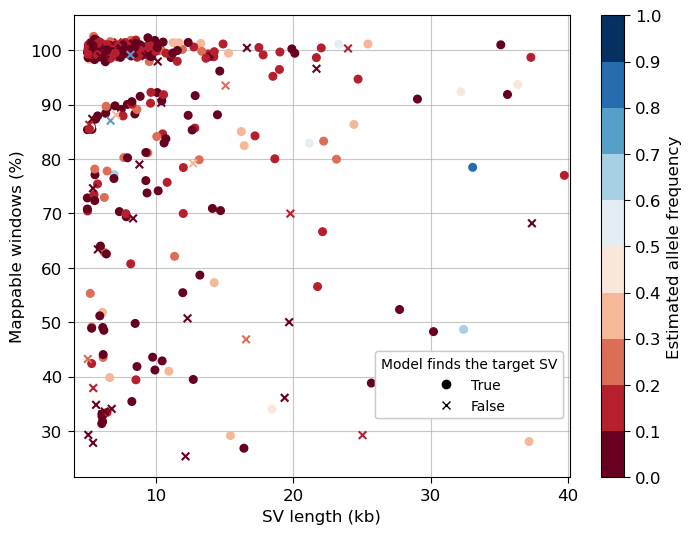

In [270]:
tmp = df2.copy()
tmp = tmp[tmp['SVTYPE'] == 'DEL']

cmap = plt.get_cmap('RdBu')
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(true))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(true))

ax.scatter(true['SVLEN'] + jitter_x, (true['callable_windows'] + jitter_y)*100, c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)

false = tmp[tmp['concordance'] == 0]
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(false))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(false))

im = ax.scatter(false['SVLEN'] + jitter_x, (false['callable_windows'] + jitter_y)*100, c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.grid(alpha = 0.7, zorder = 1)
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('Mappable windows (%)')
plt.xlim(4000, 40100)

shape_handles = [
    Line2D([0], [0], marker = 'o', color='black', linestyle='', label='True'),
    Line2D([0], [0], marker = 'x', color='black', linestyle='', label='False')
]
legend2 = plt.legend(handles=shape_handles, title='Model finds the target SV', 
                     prop={'size': 10}, framealpha=1, bbox_to_anchor = (1, 0.2))
legend2.get_title().set_fontsize(10)
plt.gca().add_artist(legend2)   
legend2.get_frame().set_zorder(2)
        
plt.show()

### Monogenic

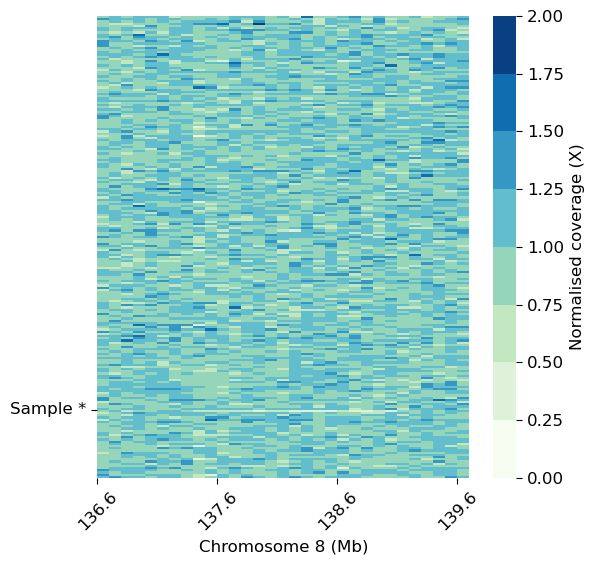

In [125]:
eichler_full = parse_eichler_full()

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 1108
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# start, end = delineate_region3(chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)
metrics = calculate_mappability_per_bin(tsv, start, end)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
metrics = pd.merge(metrics, cov[['position', 'total:mean_mq']], on = ['position'])
to_call, include_bins = assess_bins(metrics, plausible_boundaries)
n_bins = len(metrics)

tmp = cov[(cov['position'] >= start) & (cov['position'] <= end)]
mq = tmp['total:mean_mq'].to_numpy()
mean_mq = tmp['total:mean_mq'].mean()

cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
bin_size = 1e4
cov1 = deresolute_windows(cov, bin_size, normalise = False)
start,end = (136600000, 136910000)
means, variances = normalise_by_flank3(cov1, chromosome, start, end, flank)
samples, coverage = extract_target_cov(cov1, start, end)
normalised_coverage = coverage/means[np.newaxis,:]

xticks = 136.6e6 + 1e5*np.arange(4)
xtick_labels = [136.6, 137.6, 138.6, 139.6]
all_indices = np.arange(start, end, bin_size)
indices = np.where(np.isin(all_indices, xticks))[0]
sample_idx = 179

bounds = np.arange(9)*0.25
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

plt.figure(figsize=(6,6))
sns.heatmap(normalised_coverage.T, annot=False, cmap="GnBu", norm= norm, cbar=True, 
            cbar_kws={'ticks': bounds, 'label': 'Normalised coverage (X)'})
plt.xticks(indices, xtick_labels, rotation = 45)
plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.yticks([])
plt.yticks([sample_idx], ['Sample *'])
plt.show()

Text(0, 0.5, 'Normalised coverage (X)')

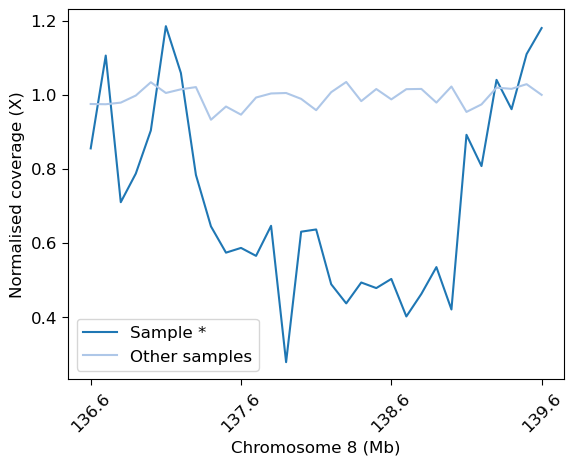

In [130]:
colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
hex_codes = [mcolors.to_hex(color) for color in colors]

plt.plot(np.arange(start, end, bin_size), 
         normalised_coverage[:,sample_idx], 
         color = colors[0], label = 'Sample *')
plt.plot(np.arange(start, end, bin_size), 
         np.delete(normalised_coverage, sample_idx, axis=1).mean(axis = 1), 
         color = colors[1], label = 'Other samples')

plt.legend()
plt.xticks(xticks, xtick_labels, rotation = 45)
plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.ylabel('Normalised coverage (X)')

### Wrong SV

In [254]:
eichler_full = parse_eichler_full()

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 868
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# start, end = delineate_region3(chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)
metrics = calculate_mappability_per_bin(tsv, start, end)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
metrics = pd.merge(metrics, cov[['position', 'total:mean_mq']], on = ['position'])
to_call, include_bins = assess_bins(metrics, plausible_boundaries)
n_bins = len(metrics)

tmp = cov[(cov['position'] >= start) & (cov['position'] <= end)]
mq = tmp['total:mean_mq'].to_numpy()
mean_mq = tmp['total:mean_mq'].mean()

cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank3(cov, chromosome, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

flanking_regions = cov[(cov['position'] >= start - flank) & (cov['position'] <= end + flank)]
flanking_regions['mean'] = flanking_regions.iloc[:,1:-1].mean(axis = 1)
flanking_regions = flanking_regions[['position', 'mean']]
f1 = flanking_regions[(flanking_regions['position'] >= start) & (flanking_regions['position'] < end)]['mean'].mean()
f2 = flanking_regions[(flanking_regions['position'] < start) | (flanking_regions['position'] >= end)]['mean'].mean()
mean_ratio = f1/f2

coverage = coverage[include_bins, :]
normalised_coverage = coverage/means[np.newaxis,:]
# results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

# probs, genotypes = results['probs'], results['genotypes']
# info, freq, concordance, true_hap_idx = evaluate_real_model3(results, plausible_boundaries, svtype, include_bins, n_bins)
# haps = results['model_ary'][-1].haps

# best_model = results['model_ary'][-1]
# calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
# plt.show()

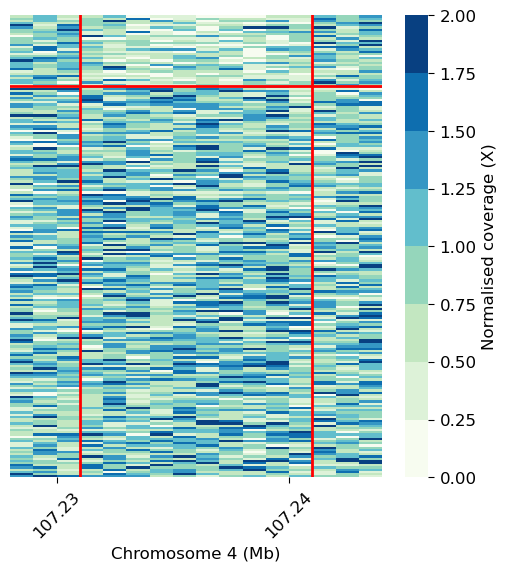

In [38]:
normalised_coverage = coverage/means[np.newaxis,:]

xticks = 107.23e6 + 1e4*np.arange(2)
xtick_labels = [107.23,107.24]
all_indices = np.arange(start, end, bin_size)
indices = np.where(np.isin(all_indices, xticks))[0]
# sample_idx = 179

bounds = np.arange(9)*0.25
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

hemi = [samples.index(s) for s in calling_dict[(0,1)]]
homo = [samples.index(s) for s in samples if s not in calling_dict[(0,1)]]
rearranged_coverage = np.hstack([normalised_coverage[:,hemi], normalised_coverage[:,homo]])

plt.figure(figsize=(6,6))
sns.heatmap(rearranged_coverage.T, annot=False, cmap="GnBu", norm= norm, cbar=True, 
            cbar_kws={'ticks': bounds, 'label': 'Normalised coverage (X)'})
plt.xticks(indices, xtick_labels, rotation = 45)
plt.xlabel(f'Chromosome {chromosome} (Mb)')

plt.axhline(y = 32, ls = '-', color = 'red', linewidth = 2)
start_idx, end_idx = plausible_boundaries
plt.axvline(x = start_idx, ls = '-', color = 'red', linewidth = 2)
plt.axvline(x = end_idx, ls = '-', color = 'red', linewidth = 2)

plt.yticks([])
# plt.yticks([sample_idx], ['Sample *'])
plt.show()

In [113]:
data = read_pickle('results/nonahore/eichler/nonahore2/region868/results.pickle')

h1 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
h21 = np.array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
h22 = np.array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1, 1.])
h23 = np.array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1, 1, 1.])
model1 = SVModel([h1, h21], data['freq'])
model2 = SVModel([h1, h22], data['freq'])
model3 = SVModel([h1, h23], data['freq'])

model0 = SVModel([h1], [1])
_, _, model0_score = multi_evaluate_model(model0, N, pre_computed_lls, geom_penalty)

N = 210
ploidy = 2
geom_penalty = 0.9
pre_computed_lls = precompute_site_lls(means/ploidy, variances/ploidy, coverage)

scores = []
probs = []
genotypes = []
infos = []

models_df = pd.DataFrame({'sample': samples})

for i,m in enumerate([model1, model2, model3]):
    _, final_lls, model_ll = multi_evaluate_model(m, N, pre_computed_lls, geom_penalty)
    best_probs = normalise_ll(final_lls)
    best_genotypes = get_best_haps(m, best_probs)
    calling_dict = call_sv_samples(samples, best_genotypes)
    info = compute_multiallelic_info(best_probs, 1)
    
    scores.append(model0_score - model_ll)
    infos.append(info)
    
    probs.append(best_probs)
    genotypes.append(calling_dict)
    
    models_df[f'Model{i+1}'] = best_probs[:,1]
    
models_df['coverage'] = normalised_coverage.mean(axis = 0)
models_df = models_df.sort_values(by = 'coverage')
hets = list(set(genotypes[0][(0,1)] + genotypes[1][(0,1)] + genotypes[2][(0,1)]))
models_df = models_df[models_df['sample'].isin(hets)]
sample_indices = models_df.index
models_df = models_df.reset_index(drop = True)
rearranged_coverage = normalised_coverage.T[sample_indices,:]

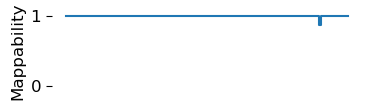

In [159]:
mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)

x = []
y = []
for _, row in tsv.iterrows():
    x.extend([row["start"], row["end"]])
    y.extend([row["value"], row["value"]])

fig, axes = plt.subplots(1, 1, figsize=(4, 1))
axes.plot(x, y, drawstyle="steps-post")
axes.set_ylim(-0.05, 1.05)

# xticks = 107.23e6 + 1e4*np.arange(2)
# xtick_labels = [107.23,107.24]

axes.set_xticks([])
axes.set_yticks([0,1], [0,1])

# plt.xticks(xticks, xtick_labels, rotation = 45)
# plt.xlabel(f"Chromosome {chromosome} (Mb)")
axes.set_ylabel("Mappability")

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)

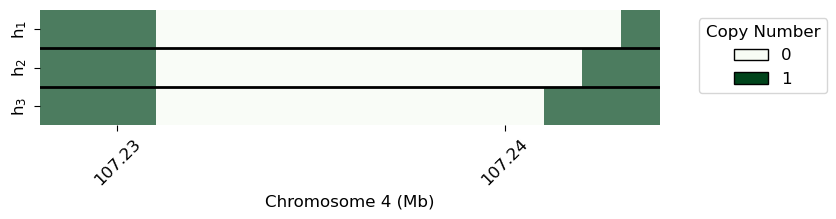

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(8,1.5))
bounds = np.arange(3)
cmap = 'Greens'
norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap).N)
colors = plt.cm.Greens(np.linspace(0,1,2))

sns.heatmap(np.vstack([h21, h22, h23]), annot=False, ax = axes, cbar = False, 
            cmap=cmap, norm= norm, alpha = 0.7)
axes.set_xticks(indices, xtick_labels, rotation = 45)
axes.set_xlabel(f'Chromosome {chromosome} (Mb)')
axes.set_yticks([0.5,1.5,2.5], ['h$_1$', 'h$_2$', 'h$_3$'])
axes.axhline(y = 1, ls = '-', color = 'black', linewidth = 2)
axes.axhline(y = 2, ls = '-', color = 'black', linewidth = 2)

legend_handles = [
    mpatches.Patch(color=colors[0], label="0", ec = 'black'),
    mpatches.Patch(color=colors[1], label="1", ec = 'black')
]
axes.legend(handles=legend_handles, title="Copy Number", 
            bbox_to_anchor=(1.05, 1), loc='upper left')

# color_legend = [mpatches.Patch(color=colors[l], label=i) for i, l in enumerate(colors)]
# legend1 = ax.legend(handles=color_legend, title="Copy Number", loc="lower left")
# ax.add_artist(legend1)
    
# plt.show()

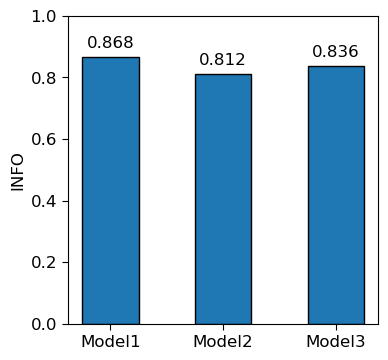

(0.0, 520.0)

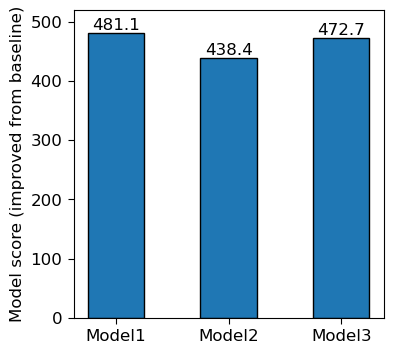

In [119]:
xindices = np.arange(3)
xticks = ['Model1', 'Model2', 'Model3']
plt.figure(figsize = (4, 4))
bars = plt.bar(xindices, infos, width = 0.5, ec = 'black')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.02,
        f"{height:.3f}",
        ha='center', va='bottom'
    )
    
plt.xticks(xindices, xticks)
plt.ylim((0,1))
plt.ylabel('INFO')
plt.show()

plt.figure(figsize = (4, 4))
bars = plt.bar(xindices, scores, width = 0.5, ec = 'black')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.02,
        f"{height:.1f}",
        ha='center', va='bottom'
    )
    
plt.xticks(xindices, xticks)
plt.ylabel('Model score (improved from baseline)')
plt.ylim((0,520))

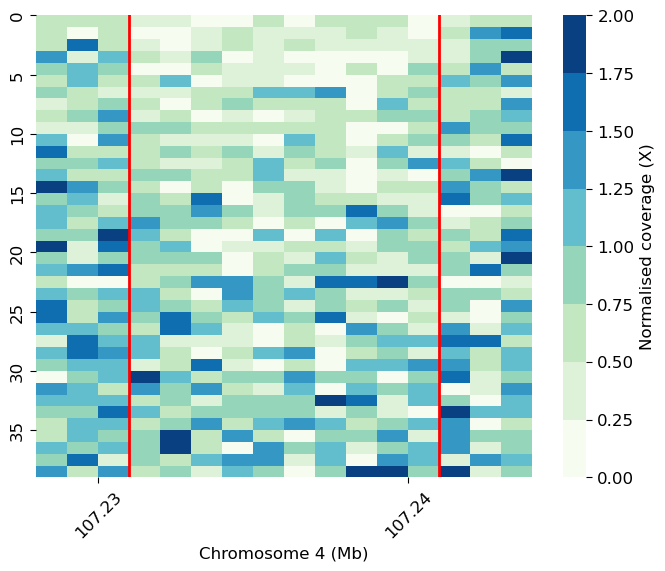

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

bounds = np.arange(9)*0.25
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

sns.heatmap(rearranged_coverage, annot=False, cmap="GnBu", ax = axes, norm= norm, cbar=True, 
            cbar_kws={'ticks': bounds, 'label': 'Normalised coverage (X)'})
axes.set_xticks(indices, xtick_labels, rotation = 45)
axes.set_xlabel(f'Chromosome {chromosome} (Mb)')

start_idx, end_idx = plausible_boundaries
axes.axvline(x = start_idx, ls = '-', color = 'red', linewidth = 2)
axes.axvline(x = end_idx, ls = '-', color = 'red', linewidth = 2)
axes.set_yticks(yticks, yticks)

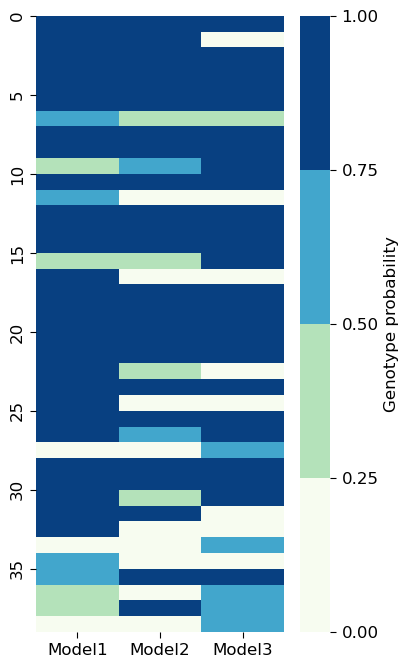

In [176]:
fig, axes = plt.subplots(1, 1, figsize=(4, 8))
bounds = np.arange(5)*0.25
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

sns.heatmap(models_df.iloc[:,1:-1], annot=False, cmap="GnBu", ax = axes, norm= norm, cbar=True, 
            cbar_kws={'ticks': bounds, 'label': 'Genotype probability'})

axes.set_yticks(yticks, yticks)

Text(68.33333333333333, 0.5, 'Samples')

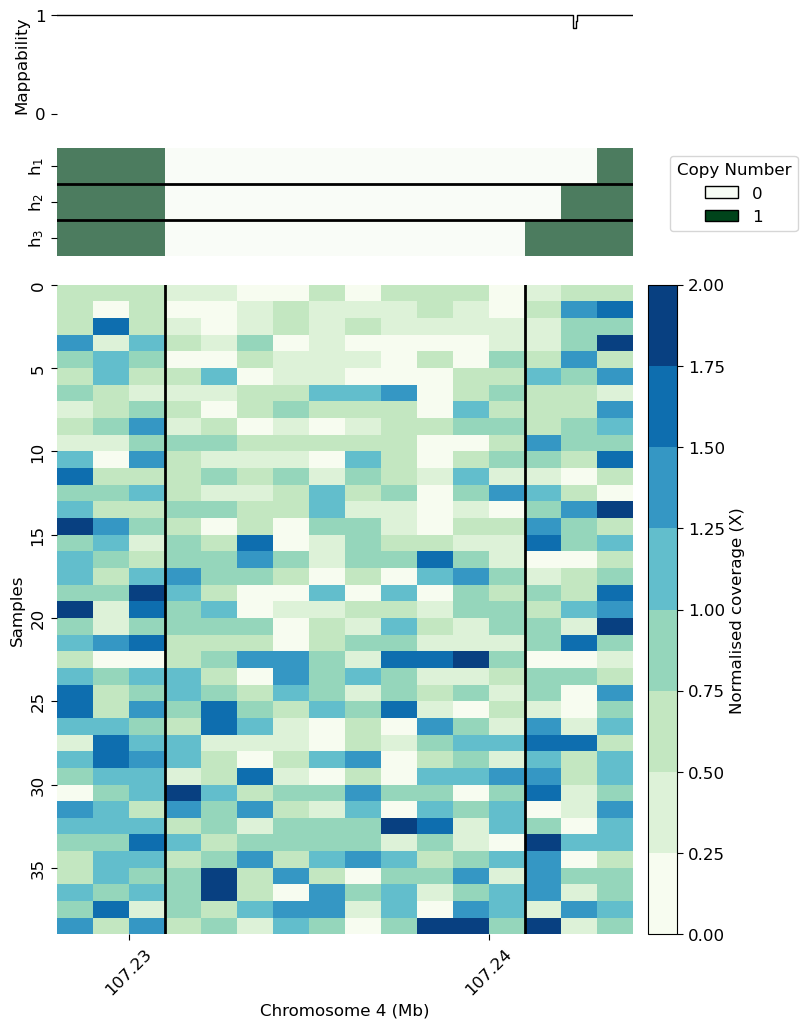

In [256]:
fig = plt.figure(figsize=(8,12))
gs = gridspec.GridSpec(3, 2, width_ratios=[20,1], height_ratios=[1,1,6], wspace=0.05, hspace=0.1)

xticks = 107.23e6 + 1e4*np.arange(2)
xtick_labels = [107.23,107.24]
all_indices = np.arange(start, end, bin_size)
indices = np.where(np.isin(all_indices, xticks))[0]

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)

x = []
y = []
for _, row in tsv.iterrows():
    x.extend([row["start"], row["end"]])
    y.extend([row["value"], row["value"]])

ax0 = fig.add_subplot(gs[0,0])
ax0.plot(x, y, drawstyle="steps-post", color='black', lw=1)
ax0.set_xticks([])
ax0.set_yticks([0,1])
ax0.set_xlim((start, end))
ax0.set_ylim(-0.05,1.05)

ax0.set_ylabel("Mappability")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)


bounds = np.arange(3)
cmap = 'Greens'
norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap).N)
colors = plt.cm.Greens(np.linspace(0,1,2))
ax1 = fig.add_subplot(gs[1,0])
sns.heatmap(np.vstack([h21,h22,h23]), annot=False, ax=ax1, cbar=False,
            cmap=cmap, norm=norm, alpha=0.7)
ax1.set_xticks([])
ax1.set_yticks([0.5,1.5,2.5], ['h$_1$','h$_2$','h$_3$'])
ax1.axhline(y=1, ls='-', color='black', lw=2)
ax1.axhline(y=2, ls='-', color='black', lw=2)
legend_handles = [
    mpatches.Patch(color=colors[0], label="0", ec = 'black'),
    mpatches.Patch(color=colors[1], label="1", ec = 'black')
]
ax1.legend(handles=legend_handles, title="Copy Number", 
            bbox_to_anchor=(1.05, 1), loc='upper left')

bounds = np.arange(9)*0.25
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

ax2 = fig.add_subplot(gs[2,0])
sns.heatmap(rearranged_coverage, annot=False, cmap="GnBu", ax=ax2, norm=norm,
            cbar=False)

cax = fig.add_subplot(gs[2,1])
sm = plt.cm.ScalarMappable(cmap="GnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, ticks=bounds, label='Normalised coverage (X)')

yticks = [0,5,10,15,20,25,30,35]
ax2.set_xticks(indices, xtick_labels, rotation=45)
ax2.set_yticks(yticks, yticks)
ax2.axvline(x=start_idx, ls='-', color='black', lw=2)
ax2.axvline(x=end_idx, ls='-', color='black', lw=2)
ax2.set_xticks(indices, xtick_labels, rotation = 45)
ax2.set_xlabel(f'Chromosome {chromosome} (Mb)')
ax2.set_ylabel('Samples')

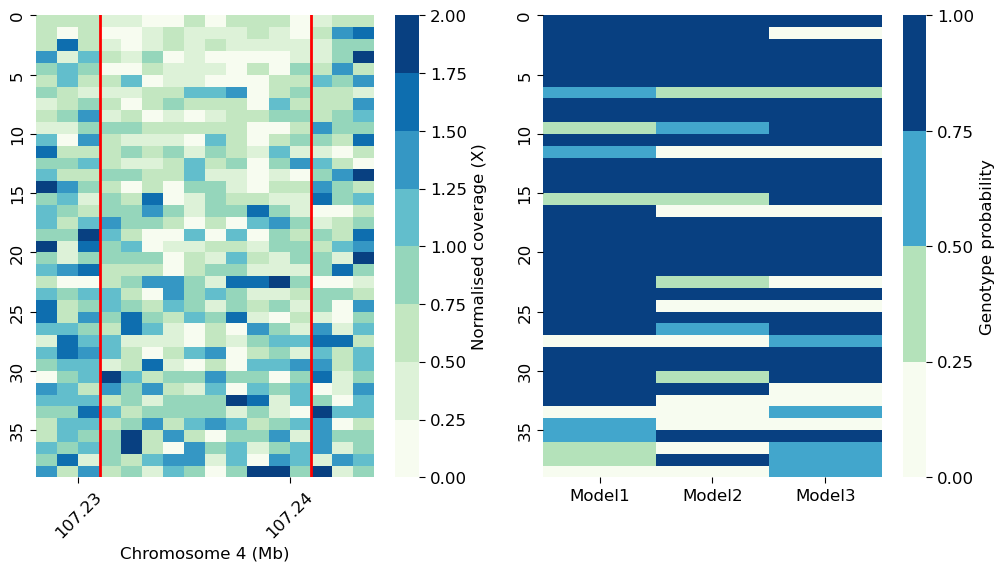

<Figure size 600x600 with 0 Axes>

In [81]:
# xticks = 107.23e6 + 1e4*np.arange(2)
# xtick_labels = [107.23,107.24]
# all_indices = np.arange(start, end, bin_size)
# indices = np.where(np.isin(all_indices, xticks))[0]
# yticks = [0,5,10,15,20,25,30,35]



# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# bounds = np.arange(9)*0.25
# norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)

# sns.heatmap(rearranged_coverage, annot=False, cmap="GnBu", ax = axes[0], norm= norm, cbar=True, 
#             cbar_kws={'ticks': bounds, 'label': 'Normalised coverage (X)'})
# axes[0].set_xticks(indices, xtick_labels, rotation = 45)
# axes[0].set_xlabel(f'Chromosome {chromosome} (Mb)')

# start_idx, end_idx = plausible_boundaries
# axes[0].axvline(x = start_idx, ls = '-', color = 'red', linewidth = 2)
# axes[0].axvline(x = end_idx, ls = '-', color = 'red', linewidth = 2)
# axes[0].set_yticks(yticks, yticks)

# bounds = np.arange(5)*0.25
# norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)
# sns.heatmap(models_df.iloc[:,1:-1], annot=False, cmap="GnBu", ax = axes[1], norm= norm, cbar=True, 
#             cbar_kws={'ticks': bounds, 'label': 'Genotype probability'})

# axes[1].set_yticks(yticks, yticks)

### Multiallelic true SV

In [178]:
svs = pd.DataFrame(columns = ['start', 'end', 'AF'])
svs.loc[len(svs)] = [1875725, 1881529, 0.08019]
svs.loc[len(svs)] = [1872338, 1881665, 0.03244]
svs.loc[len(svs)] = [1871500, 1884256, 0.02138]
svs.loc[len(svs)] = [1871246, 1876363, 0.01156]
svs['length'] = svs['end'] - svs['start']
svs

start        end       AF   length
0  1875725.0  1881529.0  0.08019   5804.0
1  1872338.0  1881665.0  0.03244   9327.0
2  1871500.0  1884256.0  0.02138  12756.0
3  1871246.0  1876363.0  0.01156   5117.0

In [196]:
eichler_full = parse_eichler_full()

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 823
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
# start, end = delineate_region3(chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)
metrics = calculate_mappability_per_bin(tsv, start, end)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
metrics = pd.merge(metrics, cov[['position', 'total:mean_mq']], on = ['position'])
to_call, include_bins = assess_bins(metrics, plausible_boundaries)
n_bins = len(metrics)

tmp = cov[(cov['position'] >= start) & (cov['position'] <= end)]
mq = tmp['total:mean_mq'].to_numpy()
mean_mq = tmp['total:mean_mq'].mean()

cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank3(cov, chromosome, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

flanking_regions = cov[(cov['position'] >= start - flank) & (cov['position'] <= end + flank)]
flanking_regions['mean'] = flanking_regions.iloc[:,1:-1].mean(axis = 1)
flanking_regions = flanking_regions[['position', 'mean']]
f1 = flanking_regions[(flanking_regions['position'] >= start) & (flanking_regions['position'] < end)]['mean'].mean()
f2 = flanking_regions[(flanking_regions['position'] < start) | (flanking_regions['position'] >= end)]['mean'].mean()
mean_ratio = f1/f2

coverage = coverage[include_bins, :]
normalised_coverage = coverage/means[np.newaxis,:]

pickle = read_pickle('results/nonahore/eichler/nonahore2/region823/results.pickle')

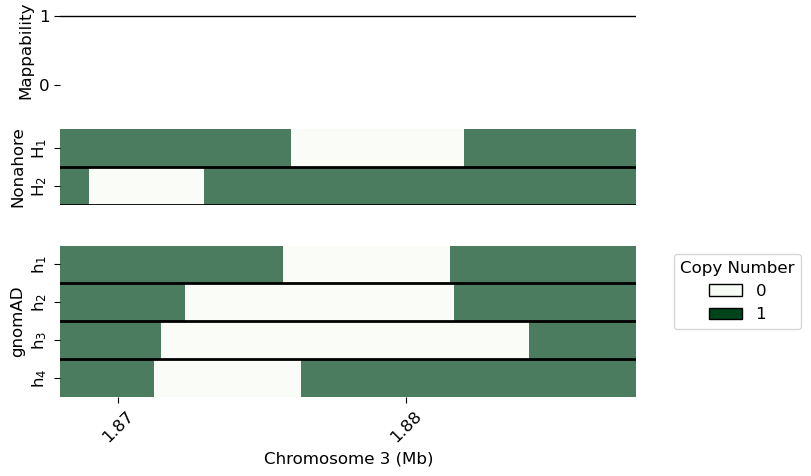

In [249]:
fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(3, 2, width_ratios=[20,1], height_ratios=[1,1,2], wspace=0.05, hspace=0.4)

mapp = '/well/band/users/rbx225/recyclable_files/eichler_sv/mappability.bed.gz'
tsv = read_bed_tabix(mapp, chromosome, start, end)

x = []
y = []
for _, row in tsv.iterrows():
    x.extend([row["start"], row["end"]])
    y.extend([row["value"], row["value"]])

ax0 = fig.add_subplot(gs[0,0])
ax0.plot(x, y, drawstyle="steps-post", color='black', lw=1)
ax0.set_xticks([])
ax0.set_yticks([0,1])
ax0.set_xlim((start, end))
ax0.set_ylim(-0.05,1.05)

ax0.set_ylabel("Mappability")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)


ax1 = fig.add_subplot(gs[1,0])
xticks = 1.87e6 + 1e4*np.arange(2)
xtick_labels = [1.87, 1.88]
all_indices = np.arange(start, end, bin_size)
indices = np.where(np.isin(all_indices, xticks))[0]

bounds = np.arange(3)
cmap = 'Greens'
norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap).N)
colors = plt.cm.Greens(np.linspace(0,1,2))

haps = pickle['haps'][1:]
sns.heatmap(np.vstack(haps), annot=False, ax = ax1, cbar = False, 
            cmap=cmap, norm= norm, alpha = 0.7)
ax1.set_xticks([])
ax1.set_yticks([0.5,1.5], ['H$_1$', 'H$_2$'])
ax1.set_ylabel('Nonahore')
ax1.axhline(y = 1, ls = '-', color = 'black', linewidth = 2)
ax1.axhline(y = 2, ls = '-', color = 'black', linewidth = 2)

# legend_handles = [
#     mpatches.Patch(color=colors[0], label="0", ec = 'black'),
#     mpatches.Patch(color=colors[1], label="1", ec = 'black')
# ]
# ax1.legend(handles=legend_handles, title="Copy Number", 
#             bbox_to_anchor=(1.05, 1), loc='upper left')



bounds = np.arange(3)
cmap = 'Greens'
norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap).N)
colors = plt.cm.Greens(np.linspace(0,1,2))

ax2 = fig.add_subplot(gs[2,0])
haps = pickle['haps'][1:]
xticks = 1.87e6 + 1e4*np.arange(2)
xtick_labels = [1.87, 1.88]
full_indices = np.arange(start, end, 1)
indices = np.where(np.isin(full_indices, xticks))[0]

sv_haps = []
for row_ix in range(len(svs)):
    regstart = svs.loc[row_ix, 'start']
    regend = svs.loc[row_ix, 'end']
    sv_hap = np.ones(len(haps[0])*1000)

    regstart = np.where(np.isin(full_indices, regstart))[0][0]
    regend = np.where(np.isin(full_indices, regend))[0][0]
    sv_hap[regstart:regend] = 0
    sv_haps.append(sv_hap)
    
sns.heatmap(sv_haps, annot=False, ax = ax2, cbar = False, 
            cmap=cmap, norm= norm, alpha = 0.7)
ax2.set_xticks(indices, xtick_labels, rotation = 45)
ax2.set_xlabel(f'Chromosome {chromosome} (Mb)')

yticks = 0.5+np.arange(len(svs))
ytick_labels = [f'h$_{i}$' for i in range(1, len(svs) + 1)]
ax2.set_yticks(yticks, ytick_labels)
ax2.set_ylabel('gnomAD')

ax2.axhline(y = 1, ls = '-', color = 'black', linewidth = 2)
ax2.axhline(y = 2, ls = '-', color = 'black', linewidth = 2)
ax2.axhline(y = 3, ls = '-', color = 'black', linewidth = 2)

legend_handles = [
    mpatches.Patch(color=colors[0], label="0", ec = 'black'),
    mpatches.Patch(color=colors[1], label="1", ec = 'black')
]
ax2.legend(handles=legend_handles, title="Copy Number", 
            bbox_to_anchor=(1.05, 1), loc='upper left')

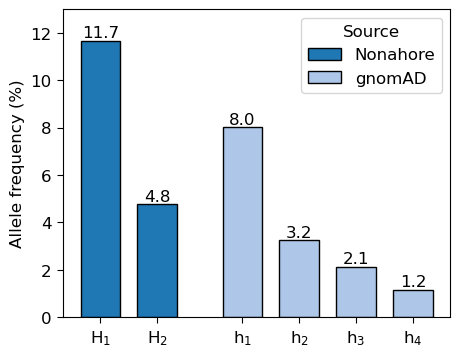

In [253]:
colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
colors = [mcolors.to_hex(c) for c in colors]
width = 0.7

plt.figure(figsize = (5, 4))

xindices1 = [0,1]
xticks1 = [f'H$_{i}$' for i in range(1, 3)]
mafs = [100*f for f in pickle['freq'][1:]]
bars = plt.bar(xindices1, mafs, width = width, color = colors[0], ec = 'black')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.02,
        f"{height:.1f}",
        ha='center', va='bottom'
    )

    
    
xindices2 = [2.5,3.5,4.5,5.5]
xticks2 = [f'h$_{i}$' for i in range(1, len(svs) + 1)]

mafs = svs['AF']
bars = plt.bar(xindices2, mafs*100, width = width, color = colors[1], ec = 'black')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.02,
        f"{height:.1f}",
        ha='center', va='bottom'
    )
    
plt.ylim((0,13))
plt.ylabel('Allele frequency (%)')


    
xindices = xindices1 + xindices2
xticks = xticks1 + xticks2
plt.xticks(xindices, xticks)

legend_handles = [
    mpatches.Patch(color=colors[0], label="Nonahore", ec = 'black'),
    mpatches.Patch(color=colors[1], label="gnomAD", ec = 'black')
]
plt.legend(handles=legend_handles, title="Source", loc='upper right')

------ Iteration 5 ------
Best loglikelihood: 65491.15075969652
------ Iteration 10 ------
Best loglikelihood: 65490.405155004126
------ Iteration 15 ------
Best loglikelihood: 65490.03929170696
------ Iteration 20 ------
Best loglikelihood: 65490.03929170696
------ Iteration 25 ------
Best loglikelihood: 65490.00710657018
------ Iteration 30 ------
Best loglikelihood: 65490.0030882604
------ Iteration 35 ------
Best loglikelihood: 65490.0030882604
------ Iteration 40 ------
Best loglikelihood: 65490.0030882604
------ Iteration 45 ------
Best loglikelihood: 65490.0030882604
------ Iteration 50 ------
Best loglikelihood: 65489.980532348905
------ Iteration 55 ------
Best loglikelihood: 65489.980532348905
------ Iteration 60 ------
Best loglikelihood: 65489.980532348905
------ Iteration 65 ------
Best loglikelihood: 65489.980532348905
------ Iteration 70 ------
Best loglikelihood: 65489.980532348905
------ Iteration 75 ------
Best loglikelihood: 65489.980532348905
------ Iteration 80 ---

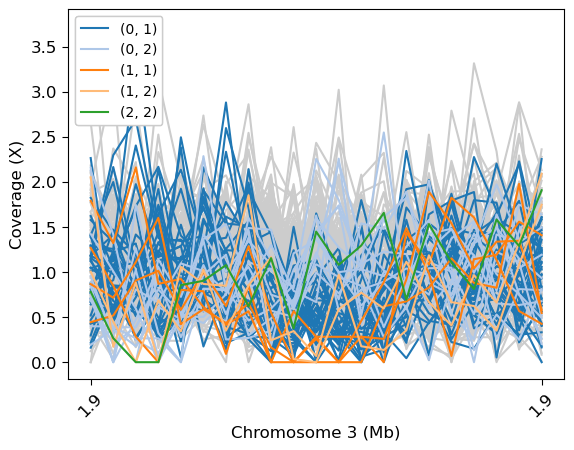

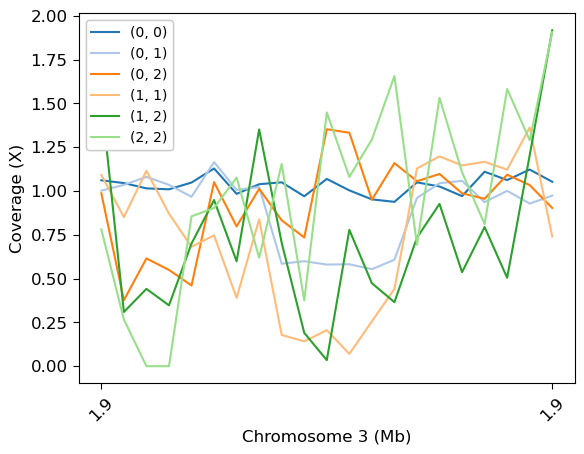

In [250]:
results = nonahore(means, variances, coverage, n_recomb = 200, n_iter = 100, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance, true_hap_idx = evaluate_real_model3(results, plausible_boundaries, svtype, include_bins, n_bins)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

### Determine confidently callable regions

In [301]:
tmp = df2.copy()
tmp = tmp[tmp['SVTYPE'] == 'DEL']
tmp = tmp[tmp['n_hap'] != 1]

tmp[(tmp['max_maf'] >= 0.05) & (~tmp['is_endchr']) & (tmp['callable_windows'] >= 0.5)]['concordance'].mean()

0.9444444444444444

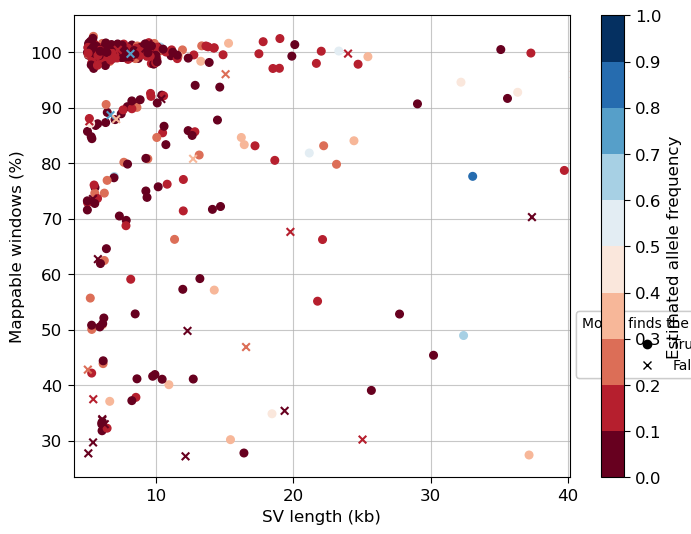

In [268]:
tmp = df2.copy()
tmp = tmp[tmp['SVTYPE'] == 'DEL']
tmp = tmp[tmp['n_hap'] != 1]

cmap = plt.get_cmap('RdBu')
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

shapes = ['o', 'x']

true = tmp[tmp['concordance'] == 1]
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(true))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(true))

ax.scatter(true['SVLEN'] + jitter_x, (true['callable_windows'] + jitter_y)*100, c = true['max_maf'], marker = 'o', alpha = 1, 
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)

false = tmp[tmp['concordance'] == 0]
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(false))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(false))

im = ax.scatter(false['SVLEN'] + jitter_x, (false['callable_windows'] + jitter_y)*100, c = false['max_maf'], marker = 'x', alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30, zorder = 3)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.grid(alpha = 0.7, zorder = 1)
plt.xticks(np.arange(5)*10000, np.arange(5)*10)
plt.xlabel('SV length (kb)')
plt.ylabel('Mappable windows (%)')
plt.xlim(4000, 40100)

shape_handles = [
    Line2D([0], [0], marker = 'o', color='black', linestyle='', label='True'),
    Line2D([0], [0], marker = 'x', color='black', linestyle='', label='False')
]
legend2 = plt.legend(handles=shape_handles, title='Model finds the target SV', 
                     prop={'size': 10}, framealpha=1, bbox_to_anchor = (1, 0.2))
legend2.get_title().set_fontsize(10)
plt.gca().add_artist(legend2)   
legend2.get_frame().set_zorder(2)
        
plt.show()

In [ ]:
def analyze_threshold(INFO, is_correct, svtype):
    INFO = np.array(INFO)
    is_correct = np.array(is_correct)

    # ROC curve
    fpr, tpr, _ = roc_curve(is_correct, INFO)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(is_correct, INFO)
    pr_auc = auc(recall, precision)

    # Sweep thresholds
    thresholds = np.linspace(50, 60, 50)
#     thresholds = np.linspace(INFO.min(), INFO.max(), 50)
    accs, precs, recs, f1s, counts = [], [], [], [], []

    for t in thresholds:
#         keep = INFO >= t
#         keep = (INFO <= t) and (svtype)
        keep = ~((INFO >= t) & (svtype == 'INS'))

        if keep.sum() == 0:
            accs.append(np.nan)
            precs.append(np.nan)
            recs.append(np.nan)
            f1s.append(np.nan)
            counts.append(0)
            continue
        y_pred = keep.astype(int)  # 1 = kept, 0 = filtered
        accs.append(accuracy_score(is_correct, y_pred))
        precs.append(precision_score(is_correct, y_pred))
        recs.append(recall_score(is_correct, y_pred))
        f1s.append(f1_score(is_correct, y_pred))
        counts.append(keep.sum())

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    
    # PR
    axes[0].plot(recall, precision, label=f"AUC={pr_auc:.2f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision–Recall")
    axes[0].legend()

    # Metrics vs Threshold
    axes[1].plot(thresholds, accs, label="Accuracy")
    axes[1].plot(thresholds, precs, label="Precision")
    axes[1].plot(thresholds, recs, label="Recall")
    axes[1].plot(thresholds, f1s, label="F1")
    axes[1].set_xlabel("Mapping quality")
    axes[1].set_ylabel("Values")
    axes[1].set_title("Metrics")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    best_idx = np.nanargmax(f1s)
    best_threshold = thresholds[best_idx]
    return best_threshold
    
tmp = df2.copy()
tmp = tmp[tmp['SVTYPE'] == 'DEL']
tmp = tmp[tmp['n_hap'] != 1]

INFO_example = tmp['max_maf'].values
is_correct_example = tmp['concordance'].values

best_mq = analyze_threshold(INFO_example, is_correct_example)
best_mq

# Pangenome

In [3]:
# df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

# n_hap_ary = []
# info_ary = []
# est_freq_ary = []

# for ix in range(len(df)):
#     infile = f'results/nonahore/eichler/region{ix}/results.pickle'
#     if os.path.exists(infile):
#         data = read_pickle(infile)
#         n_hap_ary.append(len(data['haps']))
#         info_ary.append(data['info'])
#         est_freq_ary.append(data['freq'])
#     else:
#         n_hap_ary.append(0)
#         info_ary.append(0)
#         est_freq_ary.append(0)        
    
# df['n_hap'] = n_hap_ary
# df['info'] = info_ary
# df['freq'] = est_freq_ary
df.to_csv('results/nonahore/eichler/results.5K.5percent.tsv', sep = '\t', index = None)

#CHROM        POS        END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF  n_hap  \
0      chr8  125582877  125588890    DEL   6013       0.98         1.0      4   
1      chr5   58384165   58390274    DEL   6109       1.00         1.0      3   
2     chr17   72880950   72880951    INS   8066       0.40         1.0      3   
3     chr17   72859877   72859878    INS   6353       1.00         1.0      3   
4      chr3   47784344   47784345    INS   8154       0.87         1.0      2   
...     ...        ...        ...    ...    ...        ...         ...    ...   
1174   chr2  143253209  143253210    INS   6066       0.08         0.0      2   
1175   chr2  146105051  146119294    DEL  14243       0.10         0.0      2   
1176   chr2  195227939  195227940    INS   5659       0.06         0.0      2   
1177   chr2  226090355  226097389    DEL   7034       0.06         0.0      2   
1178   chr2  229476839  229476840    INS   6030       0.06         0.0      2   

          info      freq  
0     0.000000  0.000000  
1     0.000000  0.000000  
2     0.000000  0.000000  
3     0.000000  0.000000  
4     0.818236  0.076214  
...        ...       ...  
1174  0.859208  0.050682  
1175  0.941845  0.142552  
1176  0.869972  0.044281  
1177  0.885002  0.164769  
1178  0.823171  0.070232  

[1179 rows x 10 columns]

In [6]:
df = pd.read_csv('results/nonahore/eichler/results.5K.5percent.tsv', sep = '\t')
df = df[df['SVLEN'] <= 100000]
df = df.sort_values(by = 'info', ascending = False)

#CHROM        POS        END SVTYPE   SVLEN  PG_AFR_AF  POP_AFR_AF  \
520    chr4   68508039   68625352    DEL  117313       0.25    0.181818   
686   chr19   42844938   43015693    DEL  170755       0.01    0.105263   
1003   chr4   69257983   69366597    DEL  108614       0.33    0.047619   
1103   chr8   39374555   39529709    DEL  155154       0.09    0.000000   
266    chr1   72300641   72346157    DEL   45516       0.53    0.409091   
...     ...        ...        ...    ...     ...        ...         ...   
442    chr6   22167042   22175528    DEL    8486       0.09    0.227273   
443   chr13   33558675   33564769    DEL    6094       0.15    0.227273   
444   chr21   23886057   23891137    DEL    5080       0.08    0.227273   
445    chr3  131350923  131350924    INS    6145       0.19    0.227273   
589    chr4   66095803   66105277    DEL    9474       0.00    0.136364   

      n_hap      info      freq  
520       2  1.000000  0.197605  
686       2  1.000000  0.028572  
1003      2  1.000000  0.350000  
1103      2  0.999997  0.123814  
266       2  0.999994  0.592861  
...     ...       ...       ...  
442       3  0.000000  0.000000  
443       5  0.000000  0.000000  
444       4  0.000000  0.000000  
445       3  0.000000  0.000000  
589       3  0.000000  0.000000  

[1179 rows x 10 columns]

In [8]:
pang = lcwgsus.read_vcf('/well/band/users/rbx225/recyclable_files/pangenome/pangenome.sv3000.vcf.gz')
pang

chr        pos                     ID  \
0        1     598371        >25130>24892_73   
1        1     629053         >20859>20809_1   
2        1     641040         >20340>19936_1   
3        1     669688         >18096>12814_3   
4        1     669688         >18096>12814_4   
...    ...        ...                    ...   
32748    9  138277817  >77196079>77197015_78   
32749    9  138277817  >77196079>77197015_79   
32750    9  138277817  >77196079>77197015_80   
32751    9  138277817  >77196079>77197015_81   
32752    9  138277817  >77196079>77197015_82   

                                                     ref  \
0                                                      C   
1      TATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAG...   
2      AGCTGAGACTACAGGCACCTACCACCACGCCTGGCTAATTTTTTTT...   
3                                                      G   
4                                                      G   
...                                                  ...   
32748                                                  C   
32749                                                  C   
32750                                                  C   
32751                                                  C   
32752                                                  C   

                                                     alt  QUAL FILTER  \
0      CGACACTCACGCGGGTGCCGTCTCAGCAGCTCACGGTGTGGAAACT...    60   PASS   
1                                                      T    60   PASS   
2                                                      A    60   PASS   
3      GCGGGACAGGGGGTAGGAGGCCATCAGGACAAACACGTGGATACAT...    60   PASS   
4      GCGGGACAGGGGTAGGAGACCATCAAGACAAACACGTGGATACATG...    60   PASS   
...                                                  ...   ...    ...   
32748  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32749  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32750  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32751  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32752  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   

                                                    INFO FORMAT CHM13  ...  \
0      AC=1;AF=0.0125;AN=80;AT=>25130>25129>25127>251...     GT     0  ...   
1      AC=38;AF=0.475;AN=80;AT=>20859>20858>20857>208...     GT     1  ...   
2      AC=1;AF=0.0125;AN=80;AT=>20340>20339>20333>203...     GT     0  ...   
3      AC=1;AF=0.0125;AN=80;AT=>18096>18095<18085<180...     GT     0  ...   
4      AC=1;AF=0.0125;AN=80;AT=>18096>18095<16478>164...     GT     0  ...   
...                                                  ...    ...   ...  ...   
32748  AC=2;AF=0.023256;AN=86;AT=>77196079>77196080>7...     GT     0  ...   
32749  AC=2;AF=0.023256;AN=86;AT=>77196079>77196080>7...     GT     0  ...   
32750  AC=1;AF=0.011628;AN=86;AT=>77196079>77196093<7...     GT     0  ...   
32751  AC=18;AF=0.209302;AN=86;AT=>77196079>77196093<...     GT     0  ...   
32752  AC=1;AF=0.011628;AN=86;AT=>77196079>77196093<7...     GT     0  ...   

      HG03098 HG03453 HG03486 HG03492 HG03516 HG03540 HG03579 NA18906 NA20129  \
0         .|0     0|0     0|0     0|.     0|0     0|0     0|0     0|0     0|0   
1         .|0     1|0     1|1     0|.     1|1     1|1     1|1     1|1     1|0   
2         .|0     0|0     0|0     0|.     1|0     0|0     0|0     0|0     0|0   
3         .|0     1|0     0|0     0|.     0|0     0|0     0|0     0|0     0|0   
4         .|0     0|0     0|1     0|.     0|0     0|0     0|0     0|0     0|0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
32748     0|0     0|1     0|0     0|0     0|0     0|0     0|0     0|0     1|0   
32749     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0   
32750     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0   
32751     0|0     0|0     0|0     0|0     1|0     1|0     0|0     0|0     0|0   
3275

In [12]:
pang['alt'].str.len().max()

99395